# ECCOv4 Global Volume Budget Closure

Updated 2025-07-24

Here we demonstrate the closure of volume budgets in ECCOv4 configurations.  This notebook is draws heavily from  `evaluating_budgets_in_eccov4r3.pdf` which explains the procedure with Matlab code examples by Christopher G. Piecuch.  See ECCO Version 4 release documents: */doc/evaluating_budgets_in_eccov4r3.pdf*).


## Objectives

Illustrate how volume budgets are closed globally.  


## Introduction


ECCOv4 uses the $z^*$ coordinate system in which the depth of the vertical coordinate, $z^*$ varies with time as:

$$
z^* = \frac{z - \eta(x,y,t)}{H(x,y) + \eta(x,y,t)} H(x,y)
$$

With $H$ being the model depth, $\eta$ being the model sea level anomaly, and $z$ being depth.

If the vertical coordinate didn't change through time then volume fluxes across the 'u' and 'v' grid cell faces of a tracer cell could be calculated by multiplying the velocities at the face with the face area:

volume flux across 'u' face in the +x direction = $\mathit{UVEL}(x,y,k) \times \mathit{drF}(k) \times \mathit{dyG}(x,y) \times \mathit{hFacW}(x,y,k)$

volume flux across 'v' face in the +y direction = $\mathit{VVEL}(x,y,k) \times \mathit{drF}(k) \times \mathit{dxG}(x,y) \times \mathit{hFacS}(x,y,k)$

With ``dyG`` and ``dxG`` being the lengths of the 'u' and 'v' faces, ``drF`` being the grid cell height and ``hFacW`` and ``hFacS`` being the vertical fractions of the 'u' and 'v' grid cell faces that are open water (ECCOv4 uses partial cells to better represent bathymetry which can allows 0 < hfac $\le$ 1).

However, because the vertical coordiate varies with time in the $z^*$ system, the grid cell height ``drF`` varies with time as ``drF``$\times s^*(t)$, with

$$
s^*(x,y,k,t) = 1 + \frac{\eta(x,y,t)}{H}
$$

with $s^* > 1$ when $\eta > 0$

Thus, to calculate the volume fluxes grid cell through horizontal faces we must account for the time-varying grid cell face areas:

volume flux across 'u' in the +x direction face with $z^*$ coordinates = $\mathit{UVEL}(x,y,k) \times \mathit{drF}(k) \times \mathit{dyG}(x,y) \times \mathit{hFacW}(x,y,k) \times s^*(x,y,k,t)$

volume flux across 'v' in the +y direction face with $z^*$ coordinates = $\mathit{VVEL}(x,y,k) \times \mathit{drF}(k) \times \mathit{dxG}(x,y) \times \mathit{hFacS}(x,y,k) \times s^*(x,y,k,t)$


To make budget calculations easier we provide the scaled velocities quantities ``UVELMASS`` and ``VVELMASS``,

$$
\mathit{UVELMASS}(x,y,k) = \mathit{UVEL}(x,y,k) \times \mathit{hFacW}(x,y,k) \times s^{*}(x,y,k,t)
$$
and 
$$
\mathit{VVELMASS}(x,y,k) = \mathit{VVEL}(x,y,k) \times \mathit{hFacS}(x,y,k) \times s^{*}(x,y,k,t)
$$

It is worth noting that the word **mass** in ``UVELMASS`` and ``VVELMASS`` is confusing since there is no mass involved here.  Think of these terms as simply being ``UVEL`` and ``VVEL`` multiplied by the fraction of the grid cell height that is open grid cell face across which the volume transport occurs.  Partial cell bathymetry can make this fraction (hFacW, hFacS) less than one, and the $s^*$ scaling factor further adjusts this fraction higher or lower through time.

Fully closing the budget requires the vertical volume fluxes across the top and bottom 'w' faces of the grid cell and surface freshwater fluxes.  Regarding vertical volume fluxes, there are no $s^*$ or ``hFac`` equivalent scaling factors that modify our top and bottom grid cell areas.  Therefore, vertical volume fluxes through 'w' faces are simply:

volume flux across 'w' face in the +z direction = $\mathit{WVEL}(x,y,k) \times \mathit{rA}(x,y)$

> **Note:** Inexplicably, the term ``WVEL`` is provided with the silly name ``WVELMASS``.  Sometimes it's difficult to ignore other people's poor life choices, but please try to do so here.  Ignore the confusing name, ``WVELMASS`` is identical to ``WVEL``.

In the $z^*$ coordinate system the depth of the surface grid cell is always $z^* = 0$.  In the MITgcm, ``WELMASS`` at the top of the surface grid cell is the liquid volume flux out of the ocean surface and is proportional to the vertical ocean mass flux, ``oceFWflx``

## ``ETAN`` in a Boussinesq Model

ECCOv4 uses a volume-conserving Boussinesq formulation of the MITgcm.  Because volume is conserved in Boussinesq formulations, seawater density changes do not change model sea level anomaly, ``ETAN``.  The following demonstration of``ETAN`` budget closure considers volumetric fluxes but does not take into consideration expansion/contraction due to changes in density.  Furthermore, model ``ETAN`` changes with the exchange of water between ocean and sea-ice while  in reality the Archimedes principle holds that sea level should not change following the growth or melting of sea-ice because floating sea-ice displaces a volume of seawater equal to its weight.  Thus, ``ETAN`` is not comparable to observed sea level. 

We correct ``ETAN`` to make a sea surface height field that is comaprable with observations by making three corrections: with a) the "Greatbatch correction", a time varying, globally-uniform correction to ocean volume due to changes in global mean density, b) the inverted barometer (IB) correction (see ``SSHIBC``) and c) the 'sea ice load' correction to account for the displacement of seawater due to submerged sea-ice and snow (see ``sIceLoad``).   A demonstration of these corrections is outside the scope of this tutorial.   Here we focus on closing the model budget keeping in mind that we are neglecting sea level changes from changes in global mean density and the fact that ``ETAN`` does not account for volume displacement due to submerged sea-ice.

Greatbatch, 1994. J. of Geophys. Res. Oceans, [https://doi.org/10.1029/94JC00847](https://agupubs.onlinelibrary.wiley.com/doi/10.1029/94JC00847)

## Evaluating the model sea level anomaly ``ETAN`` volume budget

We will evalute 

$$
\underbrace{\frac{\partial \eta}{\partial t}}_{G_\text{total tendency}} = \underbrace{\int_{-H}^0 \left( -\nabla_{z^*}(s^*\,{\bf v}- \frac{\partial w}{\partial z^*} \right) dz^*}_{G_{\text{volumetric divergence}}} + \underbrace{F}_{{G_{surface fluxes}}}
$$

The total tendency of $\eta$, $G_{\text{total tendency}}$ is the sum of the $\eta$ tendencies from volumetric divergence, $G_{\text{volumetric divergence}}$, and volumetric surface fluxes, $G_{\text{surface fluxes}}$. 

In discrete form, using indexes that start from k=0 (surface tracer cell) and running to k=nk-1 (bottom tracer cell)

$$
\frac{\eta(i,j)}{\partial t} = \sum_{k=nk-1}^{0} \underbrace{\left[\mathit{UVELMASS}(i_g,j,k)-\mathit{UVELMASS}(i_g+1,j,k) \right]\, \mathit{dyG}(i_g,j) \, \mathit{drF}(k) }_{\text{volumetric flux in minus out in x direction}}  + 
\\
\sum_{k=nk-1}^{0} \underbrace{\left[\mathit{VVELMASS}(i,j_g,k)-\mathit{VVELMASS}(i,j_g+1,k) \right] \, \mathit{dxG}(i,j_g) \, \mathit{drF}(k)}_{\text{volumetric flux in minus out in y direction}} +
\\
\sum_{k_l=nk}^{1} \underbrace{\mathit{WVELMASS}(i,j,k_l)\, \mathit{drA}(i,j)}_{\text{volumetric flux through grid cell bottom surface}} + 
\\
\underbrace{\mathit{oceFWflx}(i,j)/ \mathit{rhoConst}}_{\text{volumetric flux through  the top surface of the uppermost tracer cell}}
$$

In the above we intentionally sum ``WVELMASS`` fluxes from the BOTTOM surface of the lowermost grid cell (at $k_l = 50$) to the BOTTOM face of the uppermost grid cell ($k_l = 1$) so that we can explicitly include the surface volume flux (forcing) term, $\mathit{oceFWflx}(i,j)/\mathit{rhoConst}$.

We will calculate $\partial \eta / \partial t$ by differencing instantaneous monthly snapshots of $\eta$ as

$$\frac{\partial \eta}{\partial t} = \frac{\eta(i,j,t+1) - \eta(i,j,t)}{\Delta t}$$

The ``UVELMASS, VVELMASS, WVELMASS`` and ``oceFWflx`` terms must be time-average quantities between the monthly $\eta$ snapshots.

### Datasets

These are the ShortNames of the datasets that you will need for this tutorial:

- **ECCO_L4_GEOMETRY_LLC0090GRID_V4R4**
- **ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4** (1993-2016)
- **ECCO_L4_FRESH_FLUX_LLC0090GRID_MONTHLY_V4R4** (1993-2016)
- **ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4** (1993/1/1-2017/1/1, 1st of each month)
- **ECCO_L4_OBP_LLC0090GRID_SNAPSHOT_V4R4** (1993/1/1-2017/1/1, 1st of each month)

Make sure you have a recent version of `ecco_v4_py` that [includes the `ecco_access` library](https://ecco-v4-python-tutorial.readthedocs.io/ECCO_access_intro.html#Importing-ecco_access-to-your-workspace) before you run this tutorial. It will handle the access to the datasets (either in-cloud access from S3 or Internet download, depending on the `incloud_access` option you specify).


### Prepare environment and loading the relevant model variables

In [1]:
import numpy as np
import sys
import xarray as xr
import glob
from copy import deepcopy 
import matplotlib.pyplot as plt
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

from os.path import join,expanduser,exists,split
user_home_dir = expanduser('~')


import ecco_v4_py as ecco
import ecco_v4_py.ecco_access as ea


# are you working in the AWS Cloud?
incloud_access = False

# indicate mode of access from PO.DAAC
# options are:
# 'download': direct download from internet to your local machine
# 'download_ifspace': like download, but only proceeds 
#                     if your machine have sufficient storage
# 's3_open': access datasets in-cloud from an AWS instance
# 's3_open_fsspec': use jsons generated with fsspec and 
#                   kerchunk libraries to speed up in-cloud access
# 's3_get': direct download from S3 in-cloud to an AWS instance
# 's3_get_ifspace': like s3_get, but only proceeds if your instance 
#                   has sufficient storage
user_home_dir = expanduser('~')
download_dir = join(user_home_dir,'Downloads','ECCO_V4r4_PODAAC')
if incloud_access:
    access_mode = 's3_open_fsspec'
    download_root_dir = None
    jsons_root_dir = join(user_home_dir,'MZZ')
else:
    access_mode = 'download_ifspace'
    download_root_dir = download_dir
    jsons_root_dir = None

In [2]:
# setting up a dask LocalCluster
from dask.distributed import Client
from dask.distributed import LocalCluster
cluster = LocalCluster()
client = Client(cluster)
client

<Client: 'tcp://127.0.0.1:43177' processes=4 threads=4, memory=30.67 GiB>

In [3]:
# Density kg/m^3
rhoconst = 1029

## needed to convert surface mass fluxes to volume fluxes

# lat/lon resolution in degrees to interpolate the model 
# fields for the purposes of plotting
map_dx = .2
map_dy = .2

In [5]:
## access datasets needed for this tutorial

ShortNames_list = ["ECCO_L4_GEOMETRY_LLC0090GRID_V4R4",\
                   "ECCO_L4_OCEAN_3D_VOLUME_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_FRESH_FLUX_LLC0090GRID_MONTHLY_V4R4",\
                   "ECCO_L4_SSH_LLC0090GRID_SNAPSHOT_V4R4",\
                   "ECCO_L4_OBP_LLC0090GRID_SNAPSHOT_V4R4"]
StartDate = '1993-01'
EndDate = '2016-12'
ds_dict = ea.ecco_podaac_to_xrdataset(ShortNames_list,\
                                            StartDate=StartDate,EndDate=EndDate,\
                                            mode=access_mode,\
                                            download_root_dir=ECCO_dir,\
                                            jsons_root_dir=jsons_root_dir,\
                                            max_avail_frac=0.5)

### Load ecco_grid

In [7]:
ecco_grid = ds_dict[ShortNames_list[0]]

### Open 2D MONTHLY $\eta$ snapshots

In [8]:
year_start = 1993
year_end = 2016


# open ETAN snapshots (beginning of each month)
ecco_monthly_snaps_etan = (ds_dict[ShortNames_list[-2]]['ETAN']).to_dataset()
ecco_monthly_snaps_obp = ds_dict[ShortNames_list[-1]]
ecco_monthly_snaps = xr.merge((ecco_monthly_snaps_etan,ecco_monthly_snaps_obp))

# time mask for snapshots
time_snap_mask = np.logical_and(ecco_monthly_snaps.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                ecco_monthly_snaps.time.values < np.datetime64(str(year_end+1)+'-01-02','ns'))

ecco_monthly_snaps = ecco_monthly_snaps.isel(time=time_snap_mask)

In [9]:
# print time range of monthly snapshots
print(ecco_monthly_snaps.time.isel(time=[0, -1]).values)

['1993-01-01T00:00:00.000000000' '2017-01-01T00:00:00.000000000']


In [10]:
# find the record of the last ETAN snapshot
last_record_date = ecco_monthly_snaps.time[-1].values
print(last_record_date)
last_record_year = str(last_record_date)[:4]

2017-01-01T00:00:00.000000000


### Open MONTHLY mean data 

In [11]:
## Load ECCO variables
ecco_vars_uvw = ds_dict[ShortNames_list[1]]
ecco_vars_fflx = ds_dict[ShortNames_list[2]]
ecco_monthly_mean = xr.merge((ecco_vars_uvw,ecco_vars_fflx['oceFWflx']))

# time mask for monthly means
time_mean_mask = np.logical_and(ecco_monthly_mean.time.values >= np.datetime64(str(year_start)+'-01-01','ns'),\
                                ecco_monthly_mean.time.values < np.datetime64(str(year_end+1)+'-01-01','ns'))

ecco_monthly_mean = ecco_monthly_mean.isel(time=time_mean_mask)

In [12]:
ecco_monthly_mean

<xarray.Dataset> Size: 18GB
Dimensions:    (time: 288, k: 50, tile: 13, j: 90, i_g: 90, j_g: 90, i: 90,
                k_l: 50, nb: 4, nv: 2, k_p1: 51, k_u: 50)
Coordinates: (12/22)
    XC         (tile, j, i) float32 421kB -111.6 -111.3 -110.9 ... -105.6 -111.9
    XC_bnds    (tile, j, i, nb) float32 2MB ...
    XG         (tile, j_g, i_g) float32 421kB ...
    YC         (tile, j, i) float32 421kB -88.24 -88.38 -88.52 ... -88.08 -88.1
    YC_bnds    (tile, j, i, nb) float32 2MB ...
    YG         (tile, j_g, i_g) float32 421kB ...
    ...         ...
  * k_l        (k_l) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * k_p1       (k_p1) int32 204B 0 1 2 3 4 5 6 7 8 ... 43 44 45 46 47 48 49 50
  * k_u        (k_u) int32 200B 0 1 2 3 4 5 6 7 8 ... 41 42 43 44 45 46 47 48 49
  * tile       (tile) int32 52B 0 1 2 3 4 5 6 7 8 9 10 11 12
  * time       (time) datetime64[ns] 2kB 1993-01-16T12:00:00 ... 2016-12-16T1...
    time_bnds  (time, nv) datetime64[ns] 5kB ...
Dimensions without coordinates: nb, nv
Data variables:
    UVELMASS   (time, k, tile, j, i_g) float32 6GB ...
    VVELMASS   (time, k, tile, j_g, i) float32 6GB ...
    WVELMASS   (time, k_l, tile, j, i) float32 6GB ...
    oceFWflx   (time, tile, j, i) float32 121MB ...
Attributes: (12/62)
    Conventions:                     CF-1.8, ACDD-1.3
    acknowledgement:                 This research was carried out by the Jet...
    author:                          Ian Fenty and Ou Wang
    cdm_data_type:                   Grid
    comment:                         Fields provided on the curvilinear lat-l...
    coordinates_comment:             Note: the global 'coordinates' attribute...
    ...                              ...
    time_coverage_duration:          P1M
    time_coverage_end:               1992-02-01T00:00:00
    time_coverage_resolution:        P1M
    time_coverage_start:             1992-01-01T12:00:00
    title:                           ECCO Ocean Three-Dimensional Volume Flux...
    uuid:                            54fde4fa-4181-11eb-807f-0cc47a3f8057

In [13]:
# first and last monthly-mean records
print(ecco_monthly_mean.time.isel(time=[0, -1]).values)

['1993-01-16T12:00:00.000000000' '2016-12-16T12:00:00.000000000']


In [14]:
# each monthly mean record is bookended by a snapshot.  
# we should have one more snapshot than monthly mean record
print('number of monthly mean records: ', len(ecco_monthly_mean.time))
print('number of monthly snapshot records: ', len(ecco_monthly_snaps.time))

number of monthly mean records:  288
number of monthly snapshot records:  289


### Create the xgcm 'grid' object

the xgcm grid object makes it easy to make flux divergence calculations across different tiles of the lat-lon-cap grid.

In [15]:
ecco_xgcm_grid = ecco.get_llc_grid(ecco_grid)
ecco_xgcm_grid

<xgcm.Grid>
X Axis (not periodic, boundary=None):
  * center   i --> left
  * left     i_g --> center
Z Axis (not periodic, boundary=None):
  * center   k --> left
  * outer    k_p1 --> center
  * left     k_l --> center
  * right    k_u --> center
Y Axis (not periodic, boundary=None):
  * center   j --> left
  * left     j_g --> center

## Calculate LHS: $\eta$ time tendency: $G_{\text{total tendency}}$

We calculate the monthly-averaged time tendency of ``ETAN`` by differencing monthly ``ETAN`` snapshots.
Subtract the numpy arrays $\eta(t+1)$ - $\eta(t)$.  This operation gives us $\Delta$ ``ETAN`` $/ \Delta$ t (month) records.

In [16]:
num_months = len(ecco_monthly_snaps.time)
G_total_tendency_month = \
    ecco_monthly_snaps.ETAN.isel(time=range(1,num_months)).values - \
    ecco_monthly_snaps.ETAN.isel(time=range(0,num_months-1)).values

# The result is a numpy array of 264 months
print('shape of G_total_tendency_month: ', G_total_tendency_month.shape)

shape of G_total_tendency_month:  (288, 13, 90, 90)


In [17]:
ecco_monthly_mean.oceFWflx.shape

(288, 13, 90, 90)

In [18]:
# Convert this numpy array to an xarray Dataarray to take advantage 
# of xarray time indexing.
# The easiest way is to copy an existing DataArray that has the 
# dimensions and time indexes that we want,
# replace its values, and change its name.  

tmp = ecco_monthly_mean.oceFWflx.copy(deep=True)
tmp.values = G_total_tendency_month
tmp.name = 'G_total_tendency_month'
G_total_tendency_month = tmp

# the nice thing is that now the time values of G_total_tendency_month now line 
# up with the time values of the time-mean fields (middle of the month)
print('\ntime of first array of G_total_tendency_month');
print(G_total_tendency_month.time[0].values)


time of first array of G_total_tendency_month
1993-01-16T12:00:00.000000000


Now convert $\Delta$ ``ETAN`` $/ \Delta$ t (month) to $\Delta$ ``ETAN`` $/ \Delta$ t (seconds) by dividing by the number of seconds in each month.

In [19]:
secs_per_month = (ecco_monthly_snaps.time[1:].values - \
ecco_monthly_snaps.time[0:-1].values).astype('float')/(1.e9)   #divide by 1.e9 to convert ns to seconds


# Make a DataArray with the number of seconds in each month, 
#time indexed to the times in dETAN_dT_perMonth (middle of each month)
secs_per_month = xr.DataArray(secs_per_month, \
                              coords={'time': G_total_tendency_month.time.values}, \
                              dims='time')

# show number of seconds in the first two months:
print('# of seconds in Jan and Feb 1993 ', secs_per_month[0:2].values)

# sanity check: show number of days in the first two months:
print('# of days in Jan and Feb 1993 ', secs_per_month[0:2].values/3600/24)

# of seconds in Jan and Feb 1993  [2678400. 2419200.]
# of days in Jan and Feb 1993  [31. 28.]


In [20]:
# convert dETAN_dT_perMonth to perSeconds
G_total_tendency = G_total_tendency_month / secs_per_month

## Plot the time-mean $\partial \eta / \partial t$, total $\Delta \eta$, and one example $\partial \eta / \partial t$ field

### Time-mean $\partial \eta / \partial t$

To calculate the time averaged $G_{total_tendency}$ one might be tempted to do the following

``> G_total_tendency_mean = G_total_tendency.mean('time')``

But that would be folly because the 'mean' function does not know that the number of days in each month is different!  The result would downweight Februarys and upweight Julys.  We have to weight the tendency records by the length of each month.  A clever way of doing that is provided in the xarray documents: https://xarray-test.readthedocs.io/en/latest/examples/monthly-means.html

In our case we know the length of each month, we just calculated it above in ``secs_per_month``.  We will weight each month by the relative # of seconds in each month and sum to get a weighted average.

In [21]:
# the weights are just the # of seconds per month divided by total seconds
month_length_weights = secs_per_month / secs_per_month.sum()

The time mean of the ``ETAN`` tendency, $\overline{G_{\text{total tendency}}}$, is given by 

$\overline{G_{\text{total tendency}}} = \sum_{i=1}^{nm} w_i G_{\text{total tendency}}$

with $\sum_{i=1}^{nm} w_i = 1$ and  nm=number of months

In [22]:
# the weights sum to 1
print(month_length_weights.sum())

<xarray.DataArray ()> Size: 8B
array(1.)


In [23]:
# the weighted mean weights by the length of each month (in seconds)
G_total_tendency_mean = (G_total_tendency*month_length_weights).sum('time')

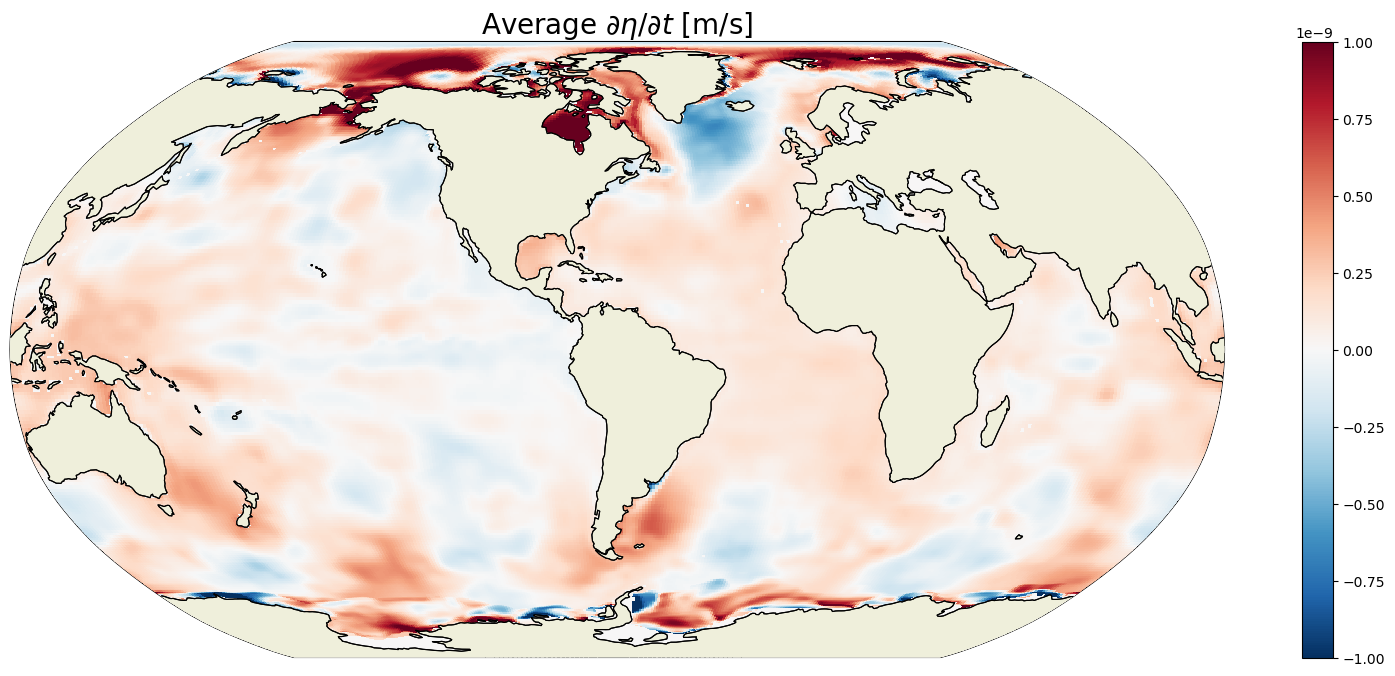

In [24]:
plt.figure(figsize=(20,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
                              G_total_tendency_mean,show_colorbar=True,\
                              cmin=-1e-9, cmax=1e-9, \
                              cmap='RdBu_r', user_lon_0=-67,\
                              dx=map_dx,dy=map_dy);
plt.title('Average $\partial \eta / \partial t$ [m/s]', fontsize=20);

### Total $\Delta \eta$


The time average eta tendency is small, about 1 billionth of a meter per second.  The ECCO period is coming up to a billion seconds though...  How much did ``ETAN`` change over the analysis period?

In [25]:
# the number of seconds in the entire period 
seconds_in_entire_period = \
    float(ecco_monthly_snaps.time[-1] - ecco_monthly_snaps.time[0])/1e9
print ('seconds in analysis period: ', seconds_in_entire_period)

# which is also the sum of the number of seconds in each month
print('sum of seconds in each month ', secs_per_month.sum().values)

seconds in analysis period:  757382400.0
sum of seconds in each month  757382400.0


In [26]:
ETAN_delta = G_total_tendency_mean*seconds_in_entire_period

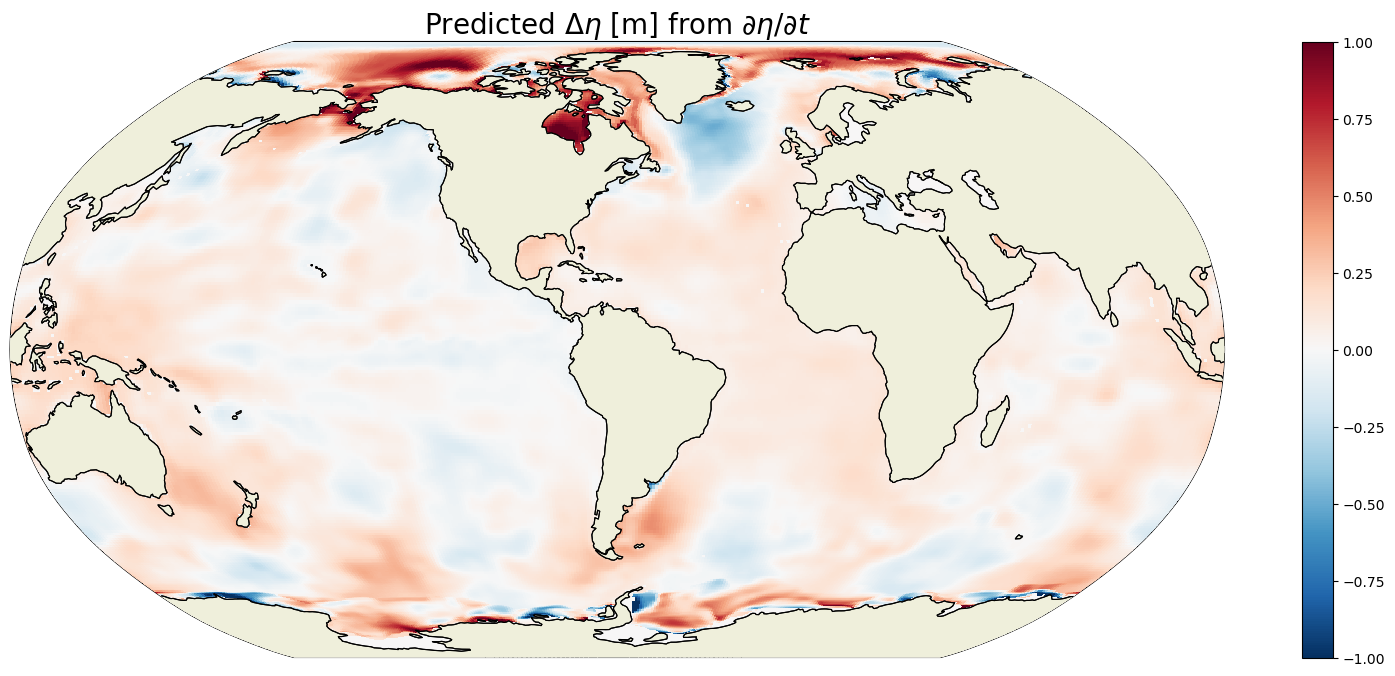

In [27]:
plt.figure(figsize=(20,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              ETAN_delta,show_colorbar=True,\
                              cmin=-1, cmax=1, \
                              cmap='RdBu_r', user_lon_0=-67, \
                              dx=map_dx,dy=map_dy);
plt.title('Predicted $\Delta \eta$ [m] from $\partial \eta / \partial t$', \
          fontsize=20);

We can sanity check the total ``ETAN`` change that we found by multipling the time-mean ``ETAN`` tendency with the number of seconds in the simulation by comparing that with the difference in ``ETAN`` between the end of the last month and start of the first month. 

In [28]:
ETAN_delta_method_2 = ecco_monthly_snaps.ETAN.isel(time=-1).values - \
    ecco_monthly_snaps.ETAN.isel(time=0).values

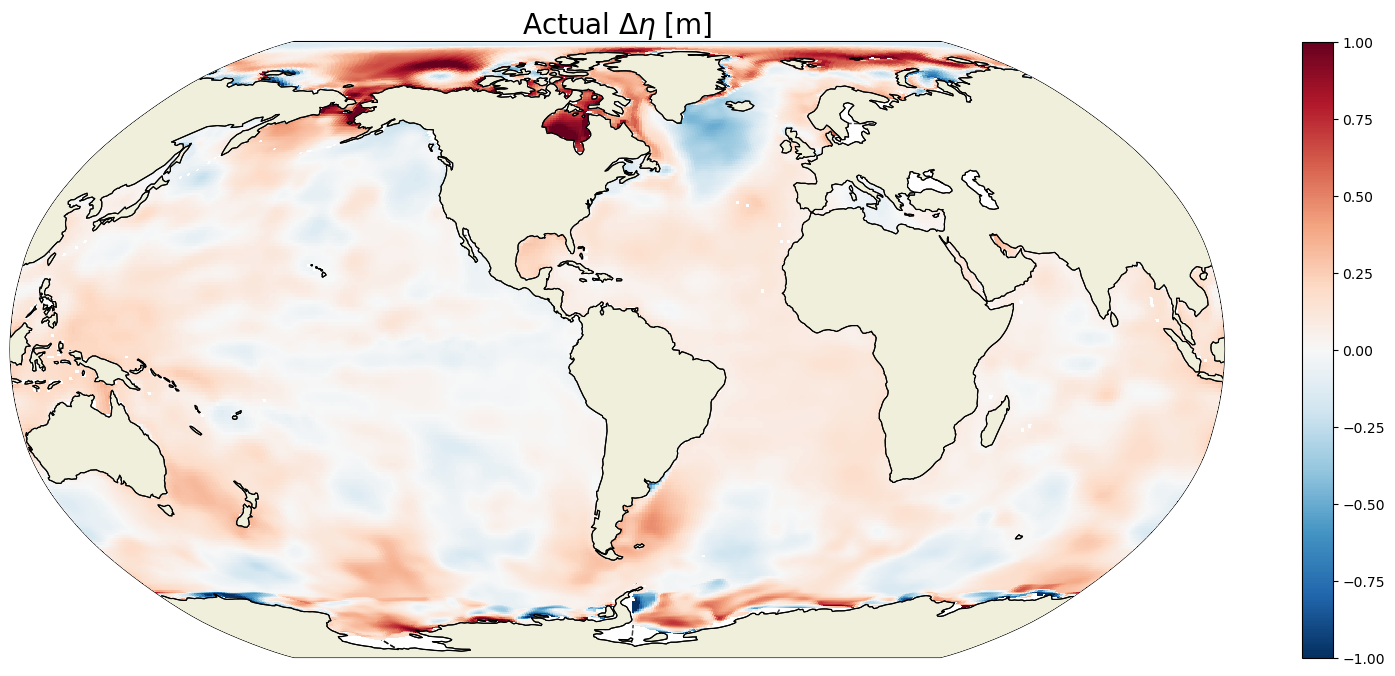

In [29]:
plt.figure(figsize=(20,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              ETAN_delta_method_2,
                              show_colorbar=True,\
                              cmin=-1, cmax=1, \
                              cmap='RdBu_r', user_lon_0=-67,\
                              dx=map_dx,dy=map_dy);

plt.title('Actual $\Delta \eta$ [m]', fontsize=20);

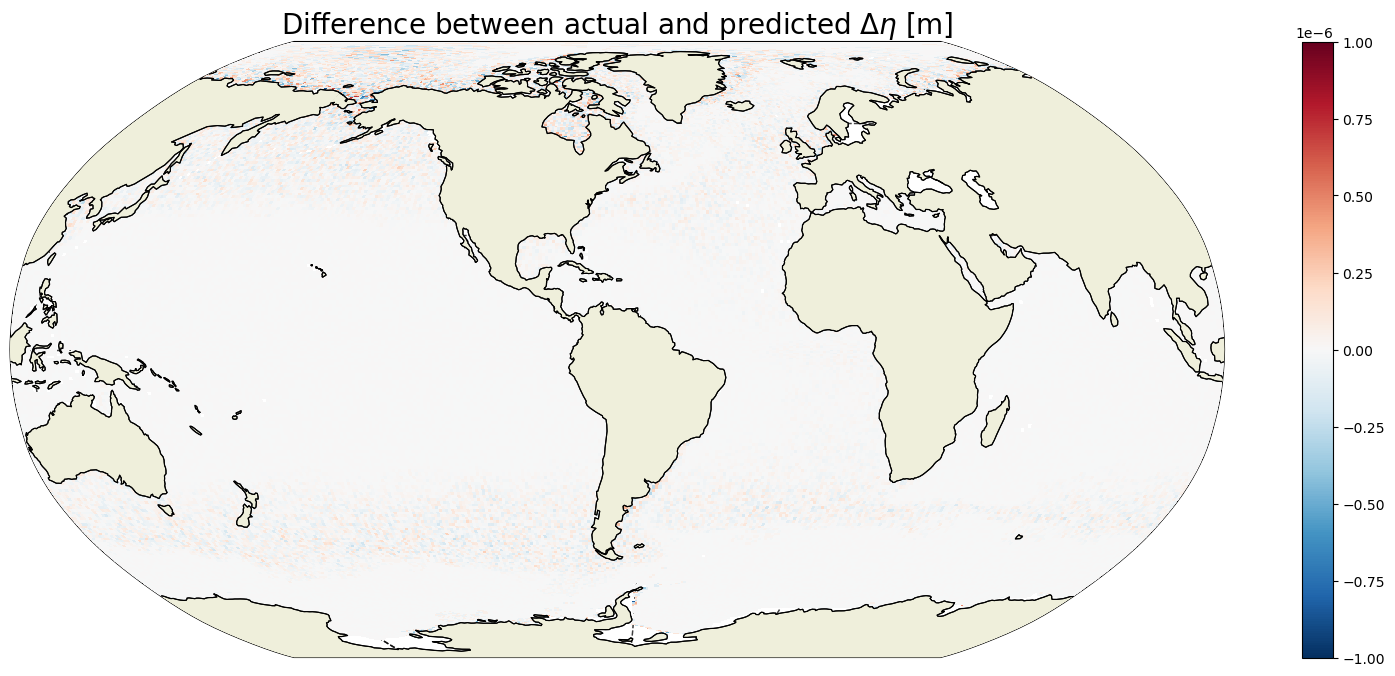

In [30]:
plt.figure(figsize=(20,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              ETAN_delta_method_2-ETAN_delta,\
                              show_colorbar=True,\
                              cmin=-1e-6, cmax=1e-6, \
                              cmap='RdBu_r', user_lon_0=-67,\
                              dx=map_dx,dy=map_dy);
plt.title('Difference between actual and predicted $\Delta \eta$ [m]', \
          fontsize=20);

That's a big woo, these are the same to within 10^-6 meters!

### Example $\partial \eta / \partial t$ field

2001-05-16T12:00:00.000000000


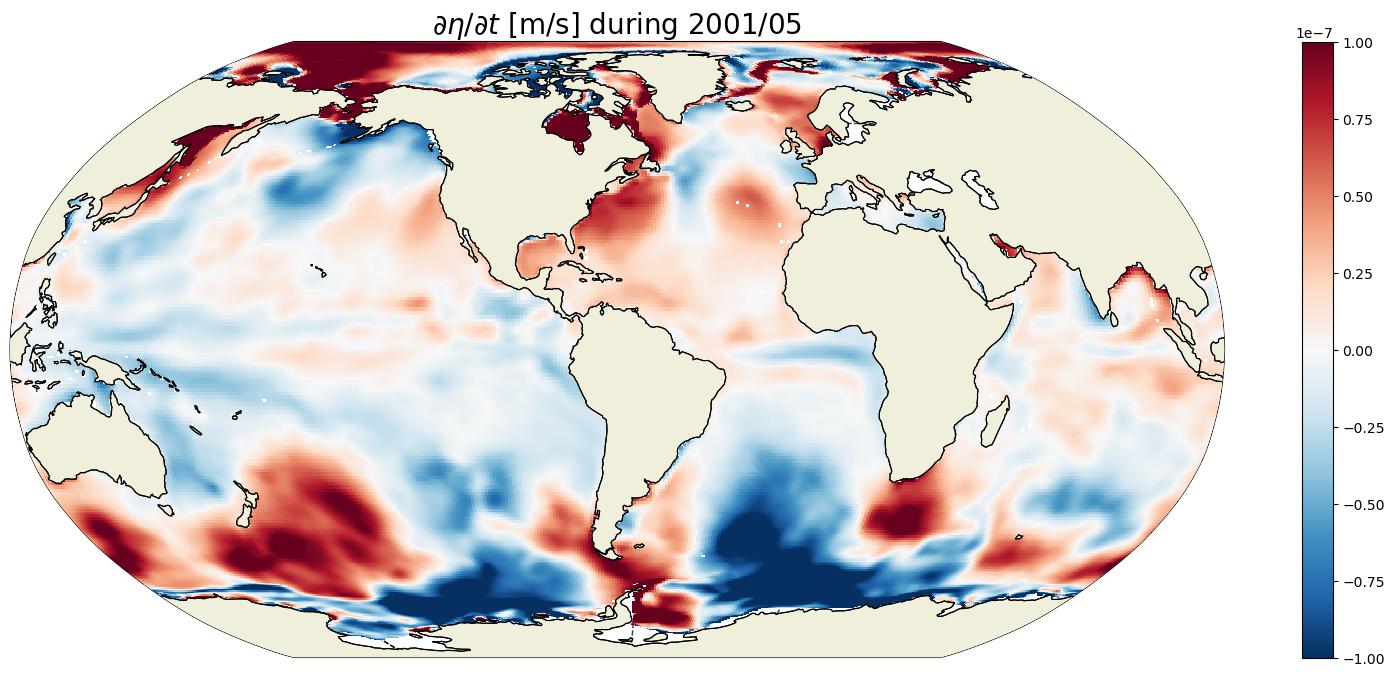

In [31]:
plt.figure(figsize=(20,8));

curr_t_ind = 100
curr_time = G_total_tendency.time[curr_t_ind].values
print(curr_time)
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              G_total_tendency.isel(time=curr_t_ind),\
                              show_colorbar=True,\
                              cmin=-1e-7, cmax=1e-7,\
                              cmap='RdBu_r', user_lon_0=-67,\
                              dx=map_dx,dy=map_dy);

plt.title('$\partial \eta / \partial t$ [m/s] during ' + 
          str(curr_time)[0:4] +'/' + str(curr_time)[5:7], fontsize=20);

For any given month the time rate of change of ``ETAN`` is two orders of magnitude smaller than the 1993-2015 mean. In the above we are looking at May 2001.  We see positive ``ETAN`` tendency due sea ice melting in the northern hemisphere (e.g., Baffin Bay, Greenland Sea, and Chukchi Sea).

## Calculate RHS: $\eta$ tendency due to surface fluxes, $G_\text{surface fluxes}$

Surface mass fluxes are given in `oceFWflx`.  Convert surface mass flux to a vertical velocity by dividing by the reference density ``rhoConst``= 1029 kg m-3

In [32]:
# tendency of eta implied by surface volume fluxes (m/s)
G_surf_fluxes = ecco_monthly_mean.oceFWflx/rhoconst

## Plot the time-mean, total, and one month average of $G_{\text{surface fluxes}}$

### Time-mean $G_{\text{surface fluxes}}$

We calculate the time-mean surface flux $\eta$ tendency using the same weights as the total $\eta$ tendency.

In [33]:
G_surf_fluxes_mean= (G_surf_fluxes*month_length_weights).sum('time')
G_surf_fluxes_mean.shape

(13, 90, 90)

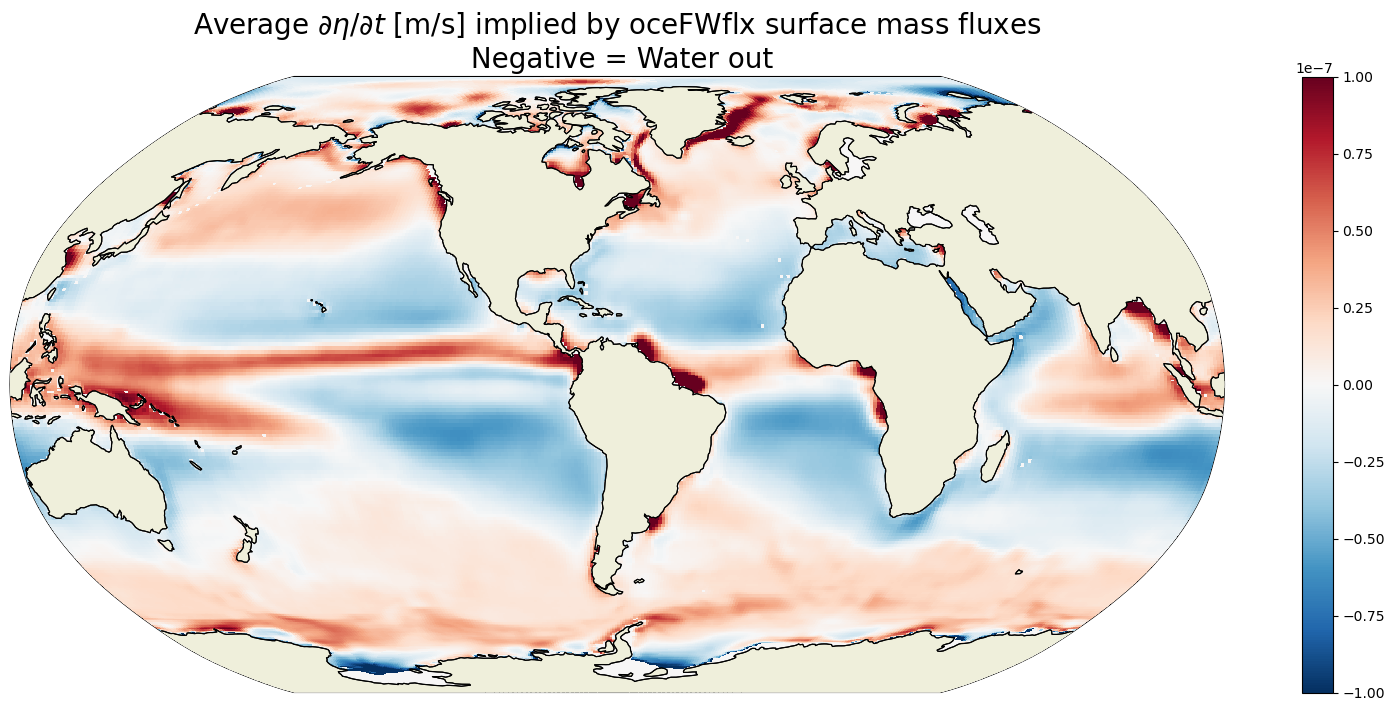

In [34]:
plt.figure(figsize=(20,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              G_surf_fluxes_mean,
                              show_colorbar=True,\
                              cmin=-1e-7, cmax=1e-7, \
                              cmap='RdBu_r', user_lon_0=-67,
                              dx=map_dx,dy=map_dy)
plt.title('Average $\partial \eta / \partial t$ [m/s] implied by oceFWflx surface mass fluxes\n Negative = Water out',
          fontsize=20);

### Total $\Delta \eta$ due to surface fluxes

If there were no other terms on the RHS to balance surface fluxes, the total change in ``ETAN`` between 1993 and 2017 would be order of 10s of meters almost everwhere.  

In [35]:
ETAN_delta_surf_fluxes = G_surf_fluxes_mean*seconds_in_entire_period

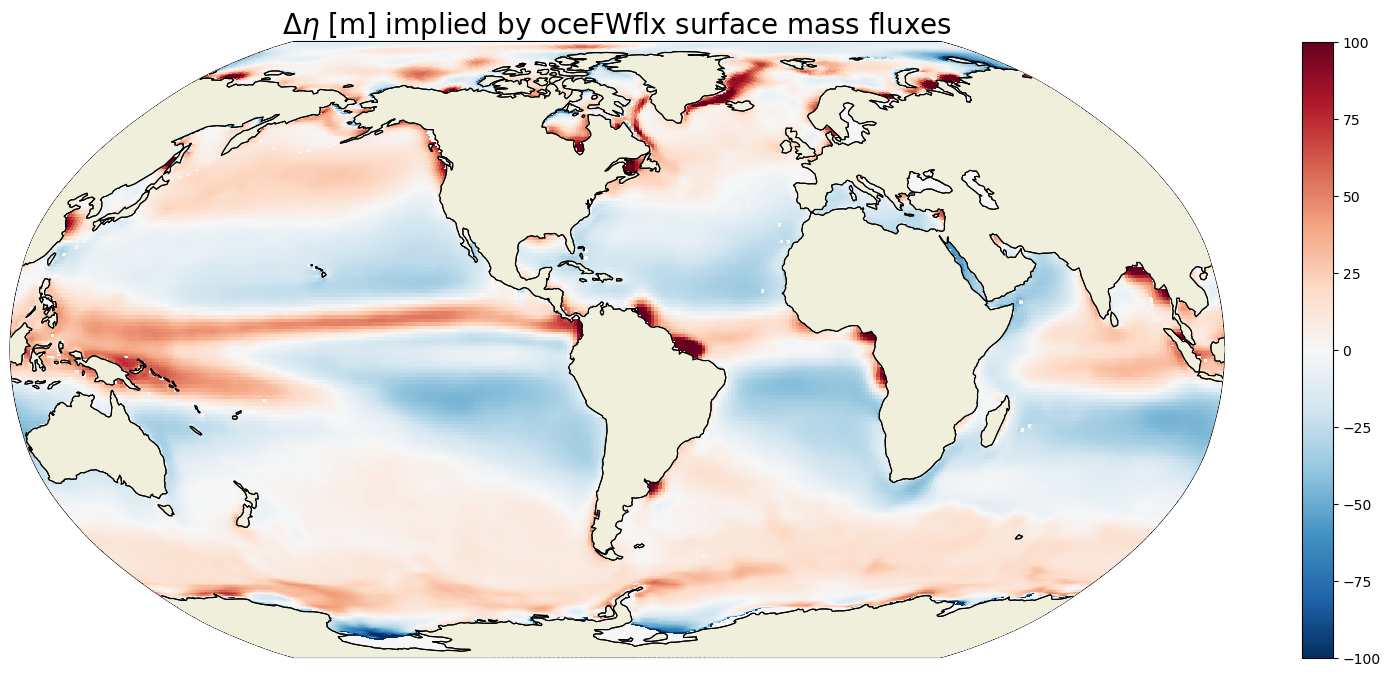

In [36]:
plt.figure(figsize=(20,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              ETAN_delta_surf_fluxes,show_colorbar=True,\
                              cmin=-100, cmax=100, \
                              cmap='RdBu_r', user_lon_0=-67, \
                              dx=map_dx,dy=map_dy);
plt.title('$\Delta \eta$ [m] implied by oceFWflx surface mass fluxes', 
          fontsize=20);

### Example $\partial \eta / \partial t$ impliedy by surface fluxes

2001-05-16T12:00:00.000000000


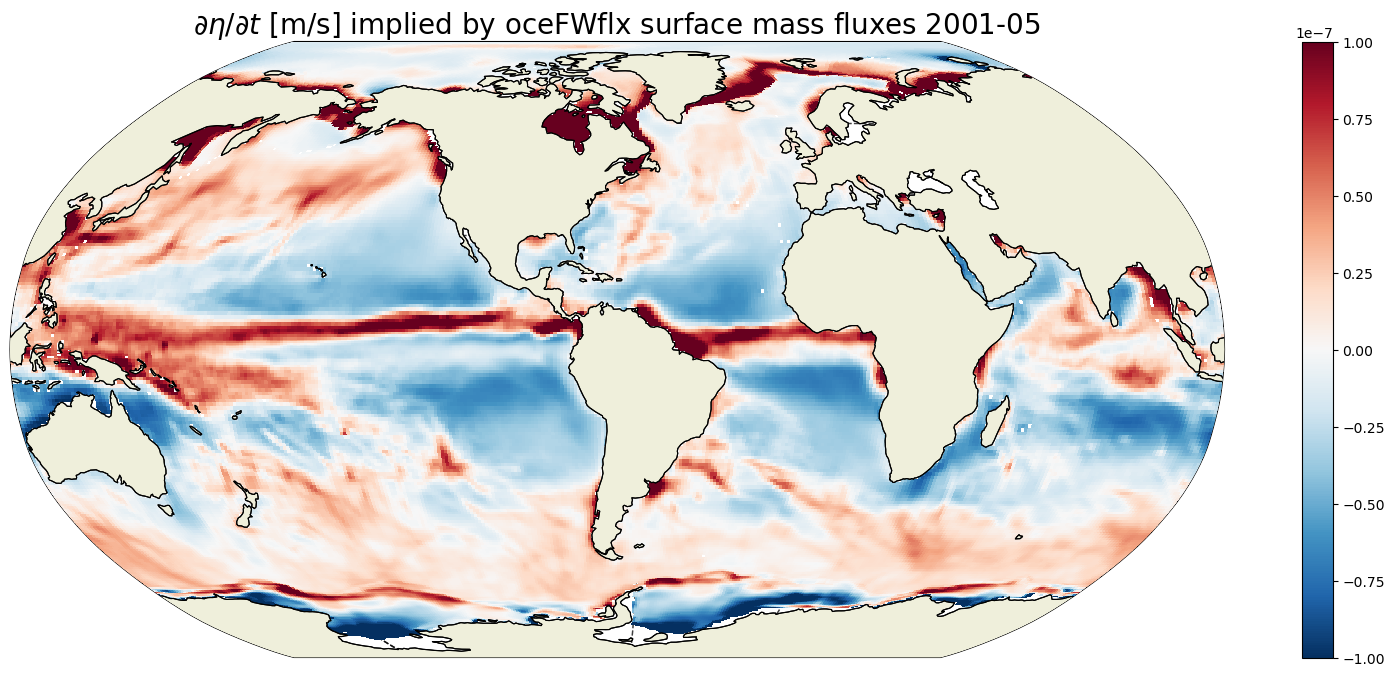

In [37]:
plt.figure(figsize=(20,8));

curr_t_ind = 100
curr_time = G_surf_fluxes.time[curr_t_ind].values
print(curr_time)
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              G_surf_fluxes.isel(time=curr_t_ind),show_colorbar=True,\
                             cmin=-1e-7, cmax=1e-7, \
                              cmap='RdBu_r', user_lon_0=-67,\
                              dx=map_dx,dy=map_dy);
plt.title('$\partial \eta / \partial t$ [m/s] implied by oceFWflx surface mass fluxes ' + 
          str(curr_time)[0:4] +'-' + str(curr_time)[5:7], fontsize=20);

For any given month the time rate of change of ``ETAN`` is almost the same as its 22 year mean.  Differences are largest in the high latitudes where sea-ice melt and growth during any particular month induce large changes in ``ETAN``.

## Calculate RHS: $\eta$ tendency due to volumetric flux divergence, $G_\text{volumetric fluxes}$

First we will look at vertical volumetric flux divergence, then horizontal volumetric flux divergence.

### Vertical volumetric flux divergence

It turns out that `WVELMASS` at k_l=0 (the top face of the top tracer cell) is proportional to the ocean surface mass flux `oceFWflx`.  The vertical velocity of the ocean surface is equal to the rate at which water is being added or removed across the top surface of the uppermost grid cell.  This is demonstrated by differencing the velocity at the top 'w' face of the uppermost tracr cell `WVELMASS` (k_l = 0) and the velocity equivalent of transporting the surface mass flux term `oceFWFlx` through this same face.

First, find the time-mean vertical velocity at the liquid ocean surface

In [38]:
WVELMASS_surf_mean = \
    (ecco_monthly_mean.WVELMASS.isel(k_l=0)*month_length_weights).sum('time')

Next, find the time-mean vertical velocity implied by the `oceFWflx` at k_l=0:

In [39]:
WVEL_from_oceFWflx_mean = \
    -(ecco_monthly_mean.oceFWflx*month_length_weights).sum('time')/rhoconst

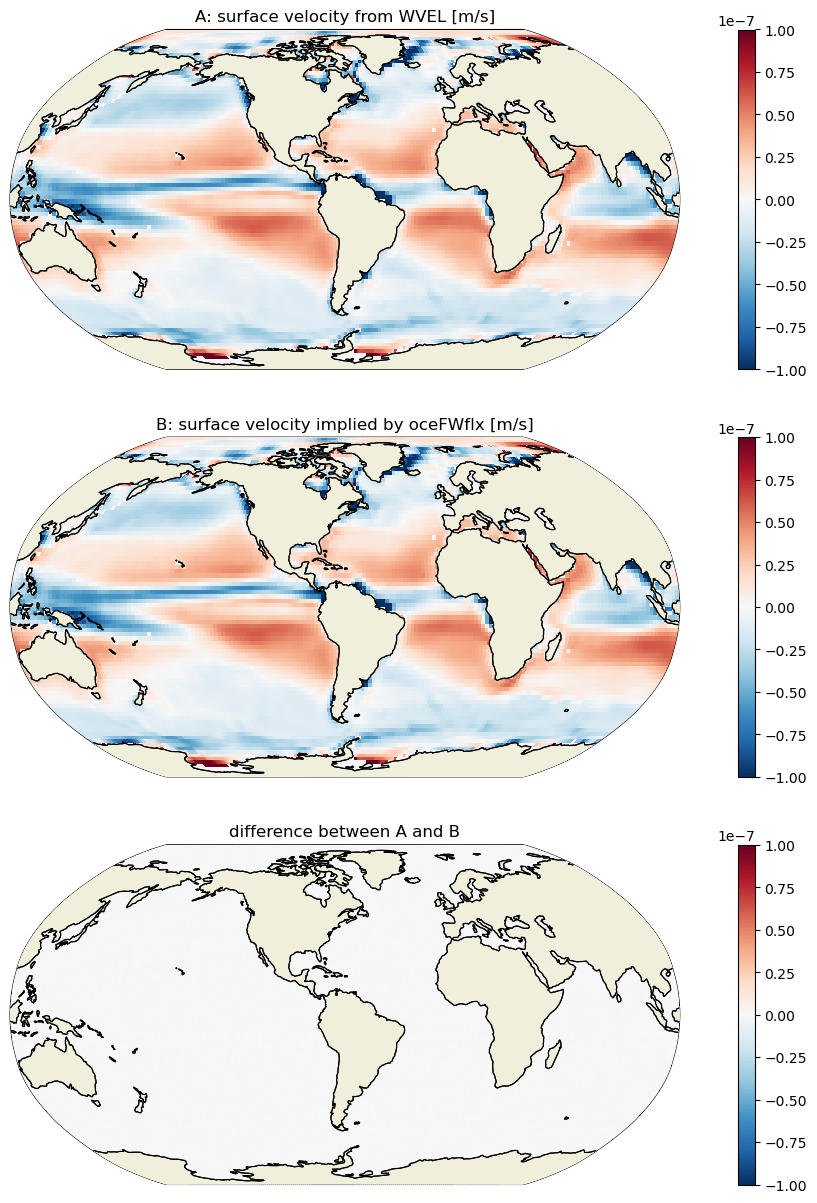

In [40]:
plt.figure(figsize=(15,15))
#plt.sca(axs[0,0])
F=ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                                WVELMASS_surf_mean,\
                                show_colorbar=True,\
                                cmin=-1e-7, cmax=1e-7, \
                                cmap='RdBu_r', user_lon_0=-67,\
                                dx=2,dy=2, subplot_grid=[3,1,1]);
F[1].set_title('A: surface velocity from WVEL [m/s]')

F=ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                                WVEL_from_oceFWflx_mean,\
                                show_colorbar=True,\
                                cmin=-1e-7, cmax=1e-7, \
                                cmap='RdBu_r', user_lon_0=-67,\
                                dx=2,dy=2, subplot_grid=[3,1,2])
F[1].set_title("B: surface velocity implied by oceFWflx [m/s]")

F=ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                                WVELMASS_surf_mean-WVEL_from_oceFWflx_mean,\
                                show_colorbar=True,\
                                cmin=-1e-7, cmax=1e-7, \
                                cmap='RdBu_r', user_lon_0=-67,\
                                dx=2,dy=2, subplot_grid=[3,1,3])
F[1].set_title("difference between A and B");


``WVELMASS`` at the surface evidently is the same as the surface velocity implied by the surface mass flux ``oceFWflx``.  Thus, we do not actually need ``oceFWflx`` to close the volume budget.  However, to keep the surface forcing term explicitly represented, we will keep ``oceFWflx`` and instead zero out the values of ``WVELMASS`` at the surface so as to avoid double counting. 

Calculate the vertical volume fluxes at each level: (velocity x grid cell area) [m3 s-1]

In [41]:
vol_transport_z = ecco_monthly_mean.WVELMASS * ecco_grid.rA

Set the volume transport at the surface level to be zero because we already counted the fluxes out of the domain with ``oceFWflx``. We will also set the volume transport in land areas (currently NaN values) to zero so the divergence adjacent to the bottom is computed correctly.

In [42]:
# vol_transport_z.isel(k_l=0).values[:] = 0
# vol_transport_z.values[ecco_grid.hFacC.values == 0] = 0

# ## For some reason the above commands don't seem to work with dask arrays, 
# ## probably due to some complication resetting the values of an existing dask array.
## However, using where works with dask arrays
vol_transport_z = vol_transport_z.where(np.expand_dims(ecco_grid.k_l.values,axis=(0,-1,-2,-3)) != 0,\
                                        0)
vol_transport_z = vol_transport_z.where(ecco_grid.hFacC.values > 0,0)

Each grid cell has a top and bottom surface and therefore ``WVELMASS ``should have 51 vertical levels (one more than the number of tracer cells).  For some reason we only have 50 vertical levels, with the bottom of the 50th tracer cell missing.  To calculate vertical flux divergence we need to add this 51st ``WVELMASS`` which is everywhere  zero (no volume flux from the seafloor). The xgcm library handles this in its `diff` routine by specifying the boundary='fill' and fill_value = 0.  

In [43]:
# re-chunk xarray DataArray for better performance
vol_transport_z = vol_transport_z.chunk({'time':12,'k_l':vol_transport_z.sizes['k_l'],'tile':1})

In [44]:
# this computation can take a little while, so we'll loop through 12 time indices (1 year)
# at a time and show when each computation has been completed

import time

G_vertical_flux_divergence_depth_integrated_time_mean = xr.DataArray(\
    data=np.zeros(vol_transport_z.shape[-3:]),dims=['tile','j','i'])
size_superchunk = 12
for time_superchunk in range(int(np.ceil(vol_transport_z.sizes['time']/size_superchunk))):
    time_log = [time.time()]
    
    curr_time_ind = np.arange(size_superchunk*time_superchunk,\
                              np.fmin(size_superchunk*(time_superchunk+1),\
                                      vol_transport_z.sizes['time']))
    
    
    # volume flux divergence into each grid cell, m^3 / s 
    vol_vert_divergence = ecco_xgcm_grid.diff(vol_transport_z.isel(time=curr_time_ind),axis='Z',\
                                              boundary='fill',fill_value=0).squeeze()
    
    # change in eta per unit time due to volumetric vertical convergence
    # at each depth level: m/s
    G_vertical_flux_divergence = vol_vert_divergence / ecco_grid.rA
    
    # change in eta per unit time due to vertical integral of 
    # volumetric horizonal convergence: m/s
    G_vertical_flux_divergence_depth_integrated = G_vertical_flux_divergence.sum('k')
        
    # Calculate the time-mean surface flux $\eta$ tendency using 
    # the same weights as the total $\eta$ tendency.
    G_vertical_flux_divergence_depth_integrated_time_mean.values += \
        (G_vertical_flux_divergence_depth_integrated * month_length_weights[curr_time_ind]).sum('time').values

    time_log = np.append(time_log,time.time())
    
    print(f'Completed calculation for time ind = {curr_time_ind[[0,-1]]}, '\
            +f'time elapsed = {np.diff(time_log)[0]} s')

Completed calculation for time ind = [ 0 11], time elapsed = 14.48197865486145 s
Completed calculation for time ind = [12 23], time elapsed = 2.9820005893707275 s
Completed calculation for time ind = [24 35], time elapsed = 2.9535562992095947 s
Completed calculation for time ind = [36 47], time elapsed = 2.851987838745117 s
Completed calculation for time ind = [48 59], time elapsed = 2.9231979846954346 s
Completed calculation for time ind = [60 71], time elapsed = 3.1725475788116455 s
Completed calculation for time ind = [72 83], time elapsed = 2.911944627761841 s
Completed calculation for time ind = [84 95], time elapsed = 2.9191393852233887 s
Completed calculation for time ind = [ 96 107], time elapsed = 3.018028974533081 s
Completed calculation for time ind = [108 119], time elapsed = 3.019850015640259 s
Completed calculation for time ind = [120 131], time elapsed = 2.9223062992095947 s
Completed calculation for time ind = [132 143], time elapsed = 3.1544744968414307 s
Completed cal

### Plot the time-mean $G_{\text{vertical flux divergence}}$

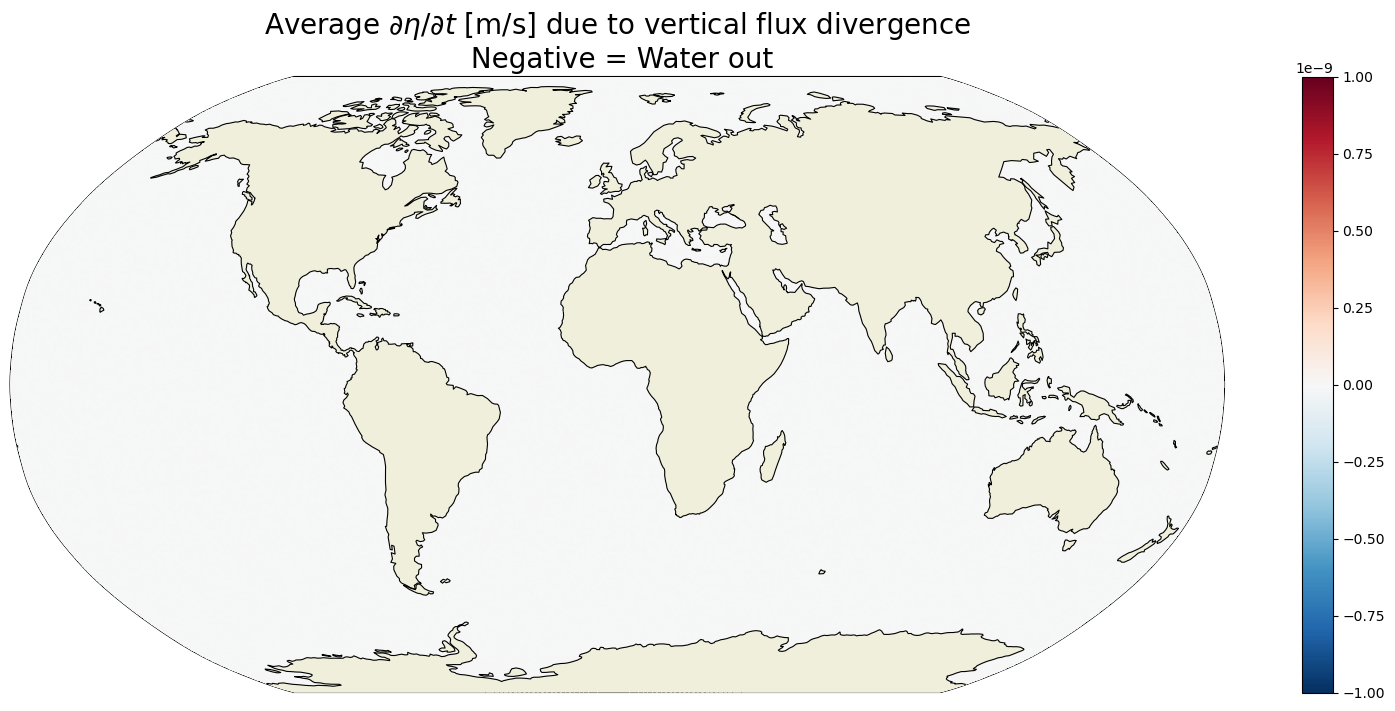

In [45]:
plt.figure(figsize=(20,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC,\
                              G_vertical_flux_divergence_depth_integrated_time_mean,\
                              show_colorbar=True,\
                              cmap='RdBu_r', \
                              cmin=-1e-9, cmax=1e-9,
                              dx=map_dx,dy=map_dy);
plt.title('Average $\partial \eta / \partial t$ [m/s] due to vertical flux divergence\n Negative = Water out',
          fontsize=20);

These values are everywhere essentially zero (numerical noise). On average, the only vertical flux divergence in the column is across the ocean surface. Below the surface, the sum of vertical flux divergence in all tracer cells in the column must be zero because any divergence in any one particular cell is exactly offset by convergence in another cell. Net convergence into the column manifests as a positive vertical velocity at the surface which is equal to oceFWflux in the time-mean. **Thanks to Hong Zhang for comments that improved this explanation.**

### Horizontal Volume Flux Divergence

In [ ]:
# Volumetric transports in x and y(m^3/s)
vol_transport_x = ecco_monthly_mean.UVELMASS * ecco_grid.dyG * ecco_grid.drF
vol_transport_y = ecco_monthly_mean.VVELMASS * ecco_grid.dxG * ecco_grid.drF

In [47]:
# Set fluxes on land to zero (instead of NaN)
vol_transport_x = vol_transport_x.where(ecco_grid.hFacW.values > 0,0)
vol_transport_y = vol_transport_y.where(ecco_grid.hFacS.values > 0,0)

# re-chunk arrays for better performance
vol_transport_x = vol_transport_x.chunk({'time':1,'k':-1,'tile':-1,'j':-1,'i_g':-1})
vol_transport_y = vol_transport_y.chunk({'time':1,'k':-1,'tile':-1,'j_g':-1,'i':-1})

In [48]:
def diff_2d_flux_llc90(flux_vector_dict):
    """
    A function that differences flux variables on the llc90 grid.
    Can be used in place of xgcm's diff_2d_vector.
    """

    u_flux = flux_vector_dict['X']
    v_flux = flux_vector_dict['Y']
    
    u_flux_padded = u_flux.pad(pad_width={'i_g':(0,1)},mode='constant',constant_values=np.nan)\
                            .chunk({'i_g':u_flux.sizes['i_g']+1})
    v_flux_padded = v_flux.pad(pad_width={'j_g':(0,1)},mode='constant',constant_values=np.nan)\
                            .chunk({'j_g':v_flux.sizes['j_g']+1})
    
    def da_replace_at_indices(da,indexing_dict,replace_values):
        # replace values in xarray DataArray using locations specified by indexing_dict
        array_data = da.data
        indexing_dict_bynum = {}
        for axis,dim in enumerate(da.dims):
            if dim in indexing_dict.keys():
                indexing_dict_bynum = {**indexing_dict_bynum,**{axis:indexing_dict[dim]}}
        ndims = len(array_data.shape)
        indexing_list = [':']*ndims
        for axis in indexing_dict_bynum.keys():
            indexing_list[axis] = indexing_dict_bynum[axis]
        indexing_str = ",".join(indexing_list)

        # using exec isn't ideal, but this works for both NumPy and Dask arrays
        exec('array_data['+indexing_str+'] = replace_values')        
        
        return da
    
    # u flux padding
    for tile in range(0,3):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+3,i_g=0).data)
    for tile in range(3,6):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              v_flux.isel(tile=12-tile,j_g=0,i=slice(None,None,-1)).data)
    u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':'6','i_g':'-1'},\
                                          u_flux.isel(tile=7,i_g=0).data)
    for tile in range(7,9):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+1,i_g=0).data)
    for tile in range(10,12):
        u_flux_padded = da_replace_at_indices(u_flux_padded,{'tile':str(tile),'i_g':'-1'},\
                                              u_flux.isel(tile=tile+1,i_g=0).data)
        
    # v flux padding
    for tile in range(0,2):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+1,j_g=0).data)
    v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':'2','j_g':'-1'},\
                                          u_flux.isel(tile=6,j=slice(None,None,-1),i_g=0).data)
    for tile in range(3,6):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+1,j_g=0).data)
    v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':'6','j_g':'-1'},\
                                          u_flux.isel(tile=10,j=slice(None,None,-1),i_g=0).data)
    for tile in range(7,10):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              v_flux.isel(tile=tile+3,j_g=0).data)
    for tile in range(10,13):
        v_flux_padded = da_replace_at_indices(v_flux_padded,{'tile':str(tile),'j_g':'-1'},\
                                              u_flux.isel(tile=12-tile,j=slice(None,None,-1),i_g=0).data)
    
    # take differences
    diff_u_flux = u_flux_padded.diff('i_g')
    diff_v_flux = v_flux_padded.diff('j_g')
    
    # include coordinates of input DataArrays and correct dimension/coordinate names
    diff_u_flux = diff_u_flux.assign_coords(u_flux.coords).rename({'i_g':'i'})
    diff_v_flux = diff_v_flux.assign_coords(v_flux.coords).rename({'j_g':'j'})

    diff_flux_vector_dict = {'X':diff_u_flux,'Y':diff_v_flux}
    
    return diff_flux_vector_dict

In [49]:
# # This way of computing horizontal volume divergence has more concise code, 
# # but it may not run optimally in some computing environments.
# # In that case, try doing the computation in "superchunks" of 12 months (1 year)
# # at a time, as coded in the next cell.


# # Difference of horizontal transports in x and y directions
# vol_flux_diff = ecco_xgcm_grid.diff_2d_vector({'X': vol_transport_x, \
#                                                'Y': vol_transport_y},\
#                                               boundary='fill')
# 
# # volume flux divergence into each grid cell, m^3 / s 
# vol_horiz_divergence = (vol_flux_diff['X'] + vol_flux_diff['Y'])
# # restore time coordinate to DataArray (lost in xgcm.diff_2d_vector operation)
# vol_horiz_divergence = vol_horiz_divergence.assign_coords({'time':vol_transport_x.time.data})
# 
# # change in eta per unit time due to volumetric horizonal
# # convergence at each depth level: m/s
# # a positive DIVERGENCE leads to negative eta tendency
# G_vol_horiz_divergence = -vol_horiz_divergence / ecco_grid.rA
# 
# # change in eta in each grid cell per unit time due to horiz. divergence: m/s
# G_vol_horiz_divergence_depth_integrated = G_vol_horiz_divergence.sum('k').compute()
# 
# # calculate time-mean using the month length weights
# G_vol_horiz_divergence_depth_integrated_mean = \
#     (G_vol_horiz_divergence_depth_integrated * month_length_weights).sum('time')

In [50]:
# complete horizontal divergence calculation, 12 time indices (1 year) at a time

import copy

area_masked = ecco_grid.rA.where(ecco_grid.hFacC.isel(k=0) > 0).compute()
area_masked_sum = area_masked.sum(dim=('i','j','tile')).values

G_vol_horiz_divergence_depth_integrated_globalmean_array = np.empty((vol_transport_x.sizes['time'],))
G_vol_horiz_divergence_depth_integrated_mean = xr.DataArray(\
    data=np.zeros(vol_transport_x.shape[-3:]),dims=['tile','j','i'])
size_superchunk = 12
for time_superchunk in range(int(np.ceil(vol_transport_x.sizes['time']/size_superchunk))):
    time_log = np.array([time.time()])
    
    curr_time_ind = np.arange(size_superchunk*time_superchunk,\
                              np.fmin(size_superchunk*(time_superchunk+1),\
                                      vol_transport_x.sizes['time']))    
    
    # # Difference of horizontal transports in x and y directions
    # # (can use either xgcm's diff_2d_vector or the diff_2d_flux_llc90
    # # function defined above)
    # vol_flux_diff = ecco_xgcm_grid.diff_2d_vector({'X': vol_transport_x.isel(time=curr_time_ind), \
    #                                                'Y': vol_transport_y.isel(time=curr_time_ind)},\
    #                                               boundary='fill')
    vol_flux_diff = diff_2d_flux_llc90({'X': vol_transport_x.isel(time=curr_time_ind),\
                                         'Y': vol_transport_y.isel(time=curr_time_ind)})
    
    # volume flux divergence into each grid cell, m^3 / s 
    vol_horiz_divergence = (vol_flux_diff['X'] + vol_flux_diff['Y'])
    
    # restore time coordinate to DataArray (lost in xgcm.diff_2d_vector operation)
    vol_horiz_divergence = vol_horiz_divergence.assign_coords({'time':vol_transport_x.time[curr_time_ind].data})
    
    # change in eta per unit time due to volumetric horizonal
    # convergence at each depth level: m/s
    # a positive DIVERGENCE leads to negative eta tendency
    curr_G_vol_horiz_divergence = -vol_horiz_divergence / ecco_grid.rA
    if curr_time_ind[0] == 0:
        G_vol_horiz_divergence = copy.deepcopy(curr_G_vol_horiz_divergence)
    else:
        G_vol_horiz_divergence = xr.concat((G_vol_horiz_divergence,\
                                            curr_G_vol_horiz_divergence),\
                                           dim='time',\
                                           coords='minimal',compat='override')
    
    # change in eta in each grid cell per unit time due to horiz. divergence: m/s
    curr_G_vol_horiz_divergence_depth_integrated = xr.DataArray(\
        data=curr_G_vol_horiz_divergence.sum('k'),dims=['time','tile','j','i'])
    if curr_time_ind[0] == 0:
        G_vol_horiz_divergence_depth_integrated = copy.deepcopy(curr_G_vol_horiz_divergence_depth_integrated)
    else:
        G_vol_horiz_divergence_depth_integrated = xr.concat((G_vol_horiz_divergence_depth_integrated,\
                                                             curr_G_vol_horiz_divergence_depth_integrated),\
                                                            dim='time',\
                                                            coords='minimal',compat='override')

    # compute global mean at each time using area weighting
    G_vol_horiz_divergence_depth_integrated_globalmean_array[curr_time_ind] = \
        (area_masked*curr_G_vol_horiz_divergence_depth_integrated).sum(dim=('i','j','tile')).values/area_masked_sum
    
    # calculate time-mean using the month length weights
    G_vol_horiz_divergence_depth_integrated_mean += \
        (curr_G_vol_horiz_divergence_depth_integrated*month_length_weights[curr_time_ind]).sum('time').values
    
    time_log = np.append(time_log,time.time())
    
    print(f'Completed calculation for time ind = {curr_time_ind[[0,-1]]}, '\
            +f'time elapsed = {np.diff(time_log)[0]} s')

# # create DataArray of global mean values
G_vol_horiz_divergence_depth_integrated_globalmean = xr.DataArray(\
    data=G_vol_horiz_divergence_depth_integrated_globalmean_array,dims=['time'],coords={'time':vol_transport_x.time})

# # calculate time-mean using the month length weights
# G_vol_horiz_divergence_depth_integrated_mean = (G_vol_horiz_divergence_depth_integrated*month_length_weights).sum('time')

Completed calculation for time ind = [ 0 11], time elapsed = 5.920902490615845 s
Completed calculation for time ind = [12 23], time elapsed = 5.610679864883423 s
Completed calculation for time ind = [24 35], time elapsed = 5.947405576705933 s
Completed calculation for time ind = [36 47], time elapsed = 5.594774961471558 s
Completed calculation for time ind = [48 59], time elapsed = 5.660876989364624 s
Completed calculation for time ind = [60 71], time elapsed = 5.619669675827026 s
Completed calculation for time ind = [72 83], time elapsed = 6.140012502670288 s
Completed calculation for time ind = [84 95], time elapsed = 5.650403738021851 s
Completed calculation for time ind = [ 96 107], time elapsed = 5.640556812286377 s
Completed calculation for time ind = [108 119], time elapsed = 5.6404054164886475 s
Completed calculation for time ind = [120 131], time elapsed = 6.055705785751343 s
Completed calculation for time ind = [132 143], time elapsed = 5.766879081726074 s
Completed calculati

### Plot the time-mean $G_{\text{horizontal flux divergence}}$

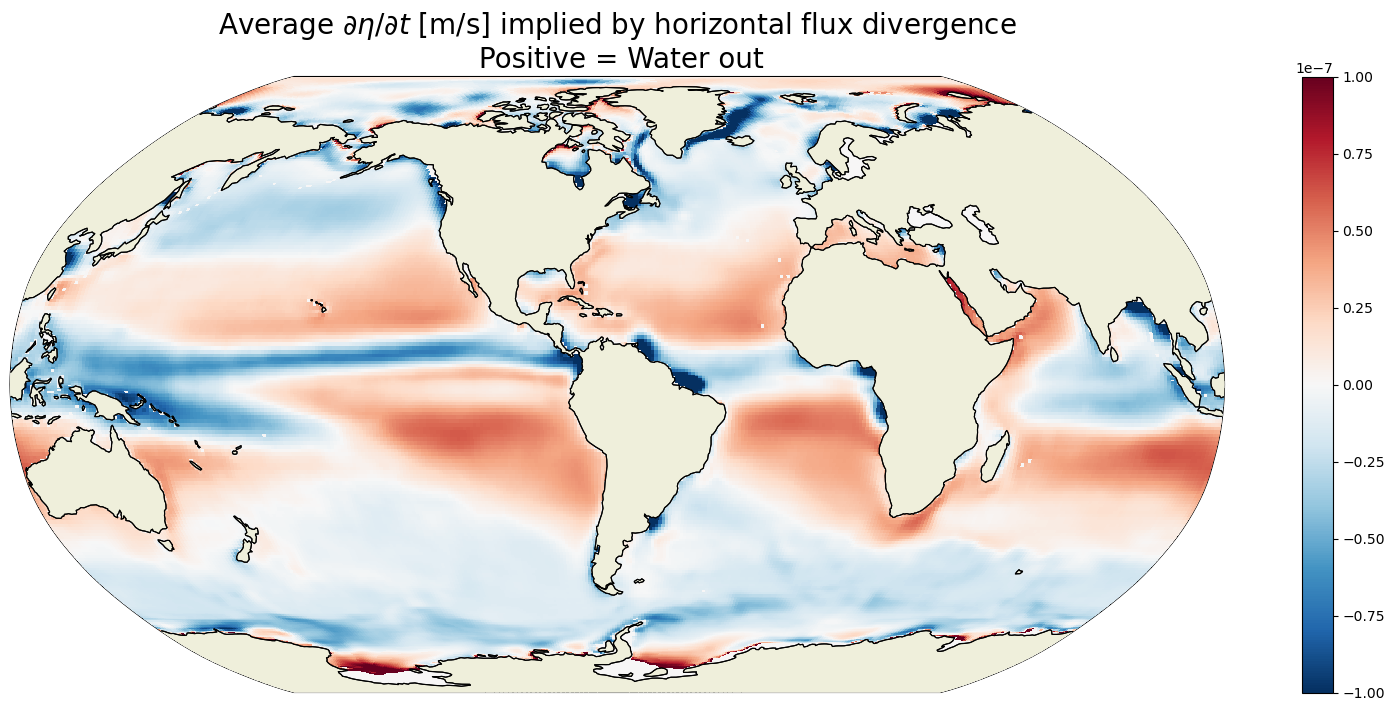

In [51]:
plt.figure(figsize=(20,8));
obj = ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              G_vol_horiz_divergence_depth_integrated_mean,\
                              show_colorbar=True,\
                              cmin=-1e-7, cmax=1e-7, \
                              cmap='RdBu_r', user_lon_0=-67,\
                              dx=map_dx,dy=map_dy);
plt.title('Average $\partial \eta / \partial t$ [m/s] implied by horizontal flux divergence\n Positive = Water out',
          fontsize=20);

### Plot one example $G_{\text{horizontal flux divergence}}$

In [52]:
G_vol_horiz_divergence_depth_integrated.shape

(288, 13, 90, 90)

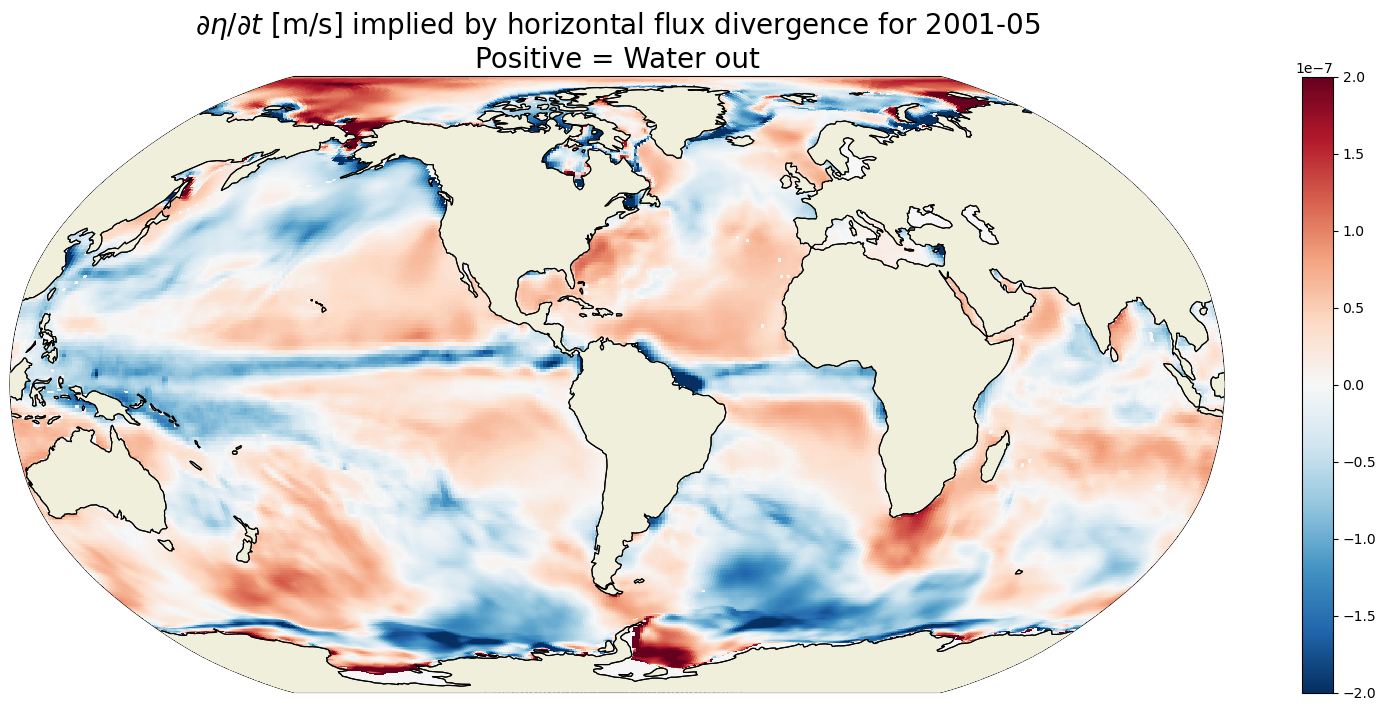

In [53]:
curr_t_ind = 100
curr_time = ecco_monthly_mean.time.values[curr_t_ind]
curr_timestr = str(curr_time)[0:4]+'-'+str(curr_time)[5:7]

plt.figure(figsize=(20,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              G_vol_horiz_divergence_depth_integrated.isel(time=curr_t_ind),
                              show_colorbar=True,\
                              cmin=-2e-7, cmax=2e-7, \
                              cmap='RdBu_r', user_lon_0=-67,\
                              dx=map_dx,dy=map_dy);
plt.title('$\partial \eta / \partial t$ [m/s] implied by horizontal flux divergence for '\
          +curr_timestr+'\nPositive = Water out',
          fontsize=20);

### Plot $G_{\text{horizontal flux divergence}}$ at 100m depth

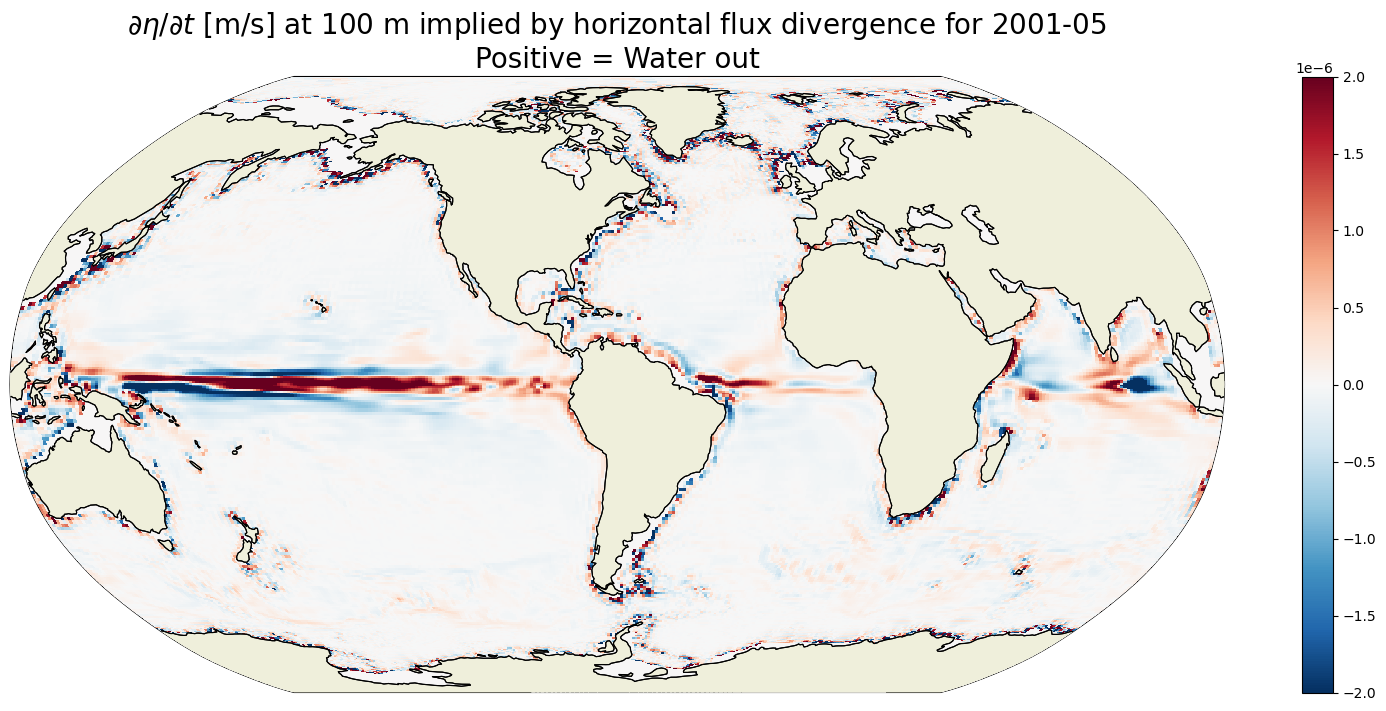

In [54]:
plt.figure(figsize=(20,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, \
                              G_vol_horiz_divergence.isel(k=10,time=curr_t_ind),
                              show_colorbar=True,\
                              cmin=-2e-6, cmax=2e-6, \
                              cmap='RdBu_r', user_lon_0=-67,\
                              dx=map_dx,dy=map_dy);
plt.title('$\partial \eta / \partial t$ [m/s] at 100 m implied by horizontal flux divergence for '\
          +curr_timestr+'\nPositive = Water out',
          fontsize=20);

## Comparison of LHS and RHS

### Time mean difference of LHR and RHS

Plot the time-mean difference between the LHS and RHS of the volume budget equation.  

In [55]:
#LHS ETA TENDENCY
a = G_total_tendency_mean
# RHS ETA TENDENCY FROM VOL DIVERGENCE AND SURFACE FLUXES
b = G_vol_horiz_divergence_depth_integrated_mean
c = G_surf_fluxes_mean

delta = a - b - c 

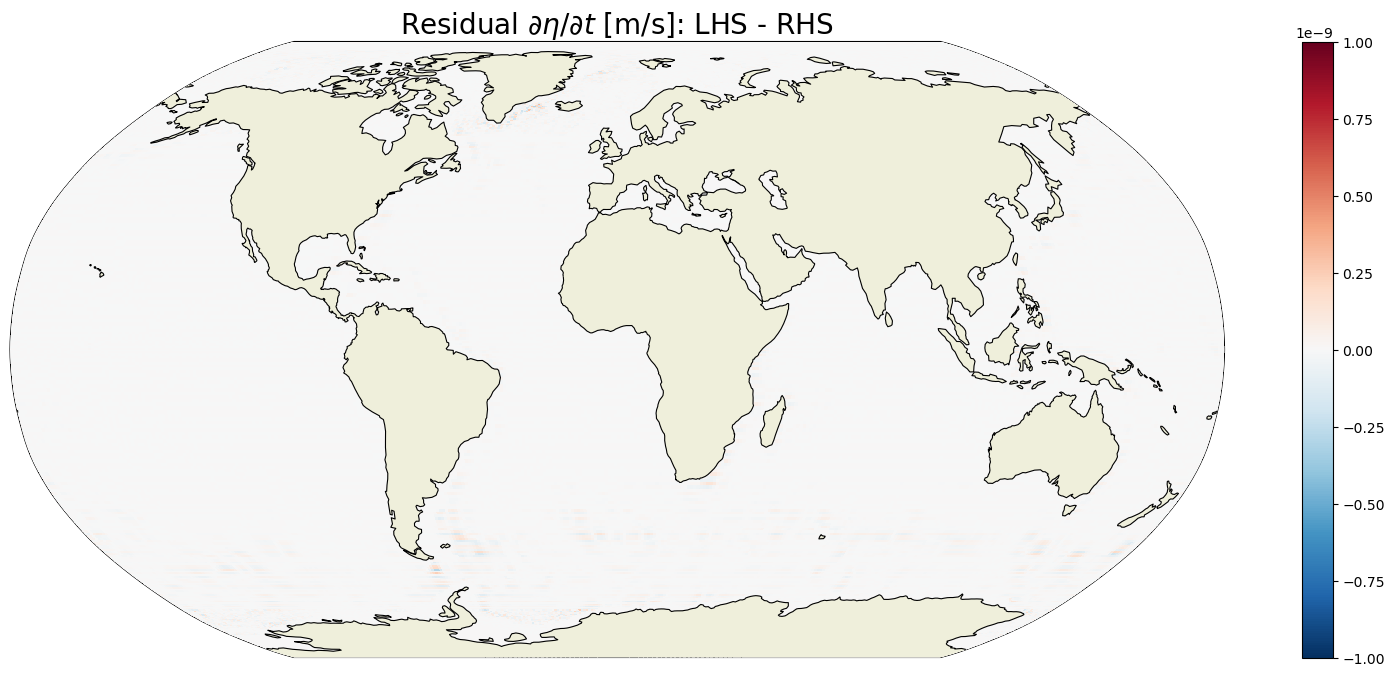

In [56]:
plt.figure(figsize=(20,8));
ecco.plot_proj_to_latlon_grid(ecco_grid.XC, ecco_grid.YC, delta, \
                              show_colorbar=True,\
                              cmin=-1e-9, cmax=1e-9, \
                              cmap='RdBu_r', \
                              dx=map_dx,dy=map_dy);
plt.title('Residual $\partial \eta / \partial t$ [m/s]: LHS - RHS ', 
          fontsize=20);

The residual of the time-mean tendency terms is essentially zero.  We can look at the distribution of residuals to get a little more confidence.

### Histogram of residuals

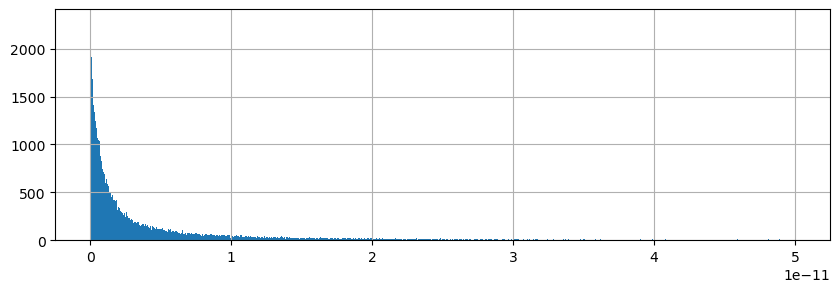

In [57]:
tmp = np.abs( a-b-c).values.ravel();
plt.figure(figsize=(10,3));

plt.hist(tmp[np.nonzero(tmp > 0)],np.linspace(0, .5e-10,1000));
plt.grid()

Almost all residuals < $10^{-11}$ m/s.  We can close the ETAN budget using UVELMASS, VVELMASS, ``WVELMASS`` and ``oceFWflx``.  

> Note: As stated earlier, we don't actually need ``oceFWflx`` because the surface velocity of ``WVELMASS`` is proportional to ``oceFWflx`` but we kept it so that the surface forcing term is explicit.

## ETAN budget closure through time

### Global average ETAN budget closure

Another way of demonstrating volume budget closure is to show the global spatially-averaged ETAN tendency terms through time

In [58]:
# LHR and RHS through time
a = G_total_tendency
b = G_vol_horiz_divergence_depth_integrated
c = G_surf_fluxes
# residuals
d = a-b-c

# area_masked = ecco_grid.rA.where(ecco_grid.hFacC.isel(k=0) > 0).compute()
# area_masked_sum = area_masked.sum(dim=('i','j','tile')).values

# take area-weighted mean of these terms
tmp_a=(a*area_masked).sum(dim=('i','j','tile')).compute()/area_masked_sum
# tmp_b=(b*area_masked).sum(dim=('i','j','tile')).compute()/area_masked_sum     # can compute global mean earlier when vol horiz div is computed
tmp_b=G_vol_horiz_divergence_depth_integrated_globalmean
tmp_c=(c*area_masked).sum(dim=('i','j','tile')).compute()/area_masked_sum
# tmp_d=(d*area_masked).sum(dim=('i','j','tile'))/area_masked_sum
tmp_d = tmp_a - tmp_b - tmp_c

# result is four time series
tmp_a.dims

('time',)

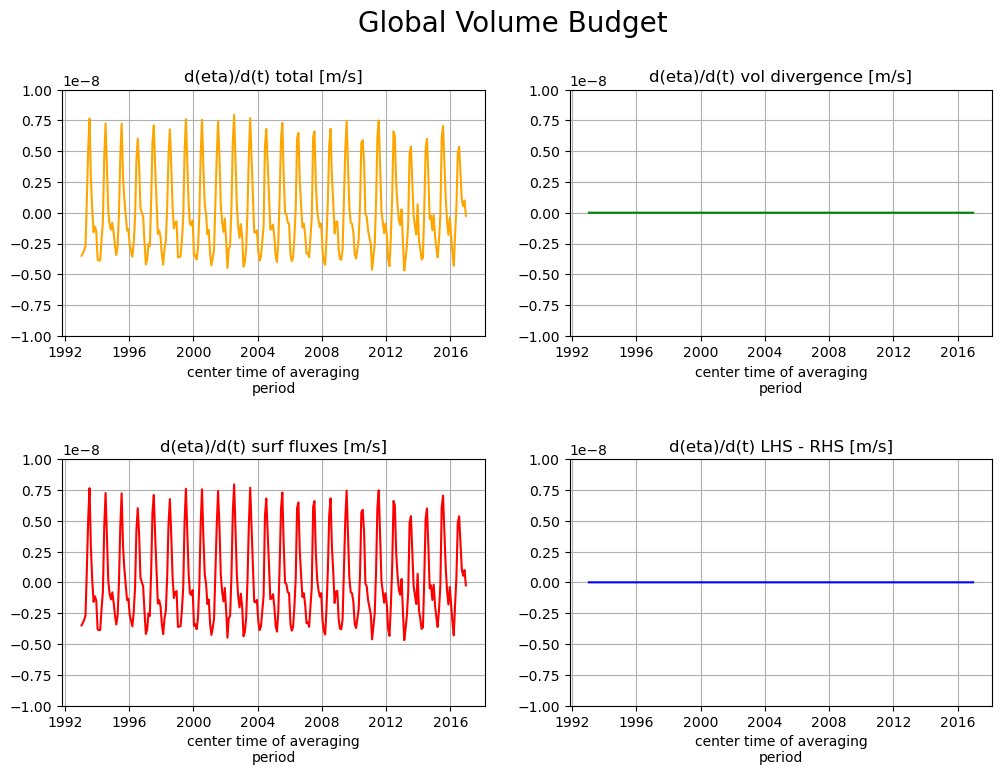

In [59]:
fig, axs = plt.subplots(2, 2, figsize=(12,8))

plt.sca(axs[0,0])
tmp_a.plot(color='orange')
axs[0,0].set_title("d(eta)/d(t) total [m/s]")
plt.grid()
plt.ylim([-1e-8, 1e-8]);

plt.sca(axs[0,1])
tmp_b.plot(color='g')
axs[0,1].set_title("d(eta)/d(t) vol divergence [m/s]")
plt.grid()
plt.ylim([-1e-8, 1e-8]);

plt.sca(axs[1,0])
tmp_c.plot(color='r')
axs[1,0].set_title("d(eta)/d(t) surf fluxes [m/s]")
plt.grid()
plt.ylim([-1e-8, 1e-8]);

plt.sca(axs[1,1])
tmp_d.plot(color='b')
axs[1,1].set_title("d(eta)/d(t) LHS - RHS [m/s]")
plt.grid()
plt.subplots_adjust(hspace = .5, wspace=.2)
plt.ylim([-1e-8, 1e-8])
plt.suptitle('Global Volume Budget',fontsize=20);

When averaged over the entire ocean surface the volumetric divergence has no net impact on $\partial \eta / \partial t$.  This makes sence because horizontal flux divergence can only redistribute volume.  Globally, $\eta$ can only change via net surface fluxes.

### Local ETAN budget closure

Locally we expect that volume divergence can impact $\eta$.  This is demonstrated for a single point the Arctic.

In [60]:
# close distributed client (removes overhead of distributed client with numerous small chunks)
client.close()

Completed time_superchunk = 0
Completed time_superchunk = 1
Completed time_superchunk = 2
Completed time_superchunk = 3
Completed time_superchunk = 4
Completed time_superchunk = 5
Completed time_superchunk = 6
Completed time_superchunk = 7
Completed time_superchunk = 8
Completed time_superchunk = 9
Completed time_superchunk = 10
Completed time_superchunk = 11
Completed time_superchunk = 12
Completed time_superchunk = 13
Completed time_superchunk = 14
Completed time_superchunk = 15
Completed time_superchunk = 16
Completed time_superchunk = 17
Completed time_superchunk = 18
Completed time_superchunk = 19
Completed time_superchunk = 20
Completed time_superchunk = 21
Completed time_superchunk = 22
Completed time_superchunk = 23
CPU times: user 37.9 s, sys: 2.41 s, total: 40.3 s
Wall time: 13.7 s


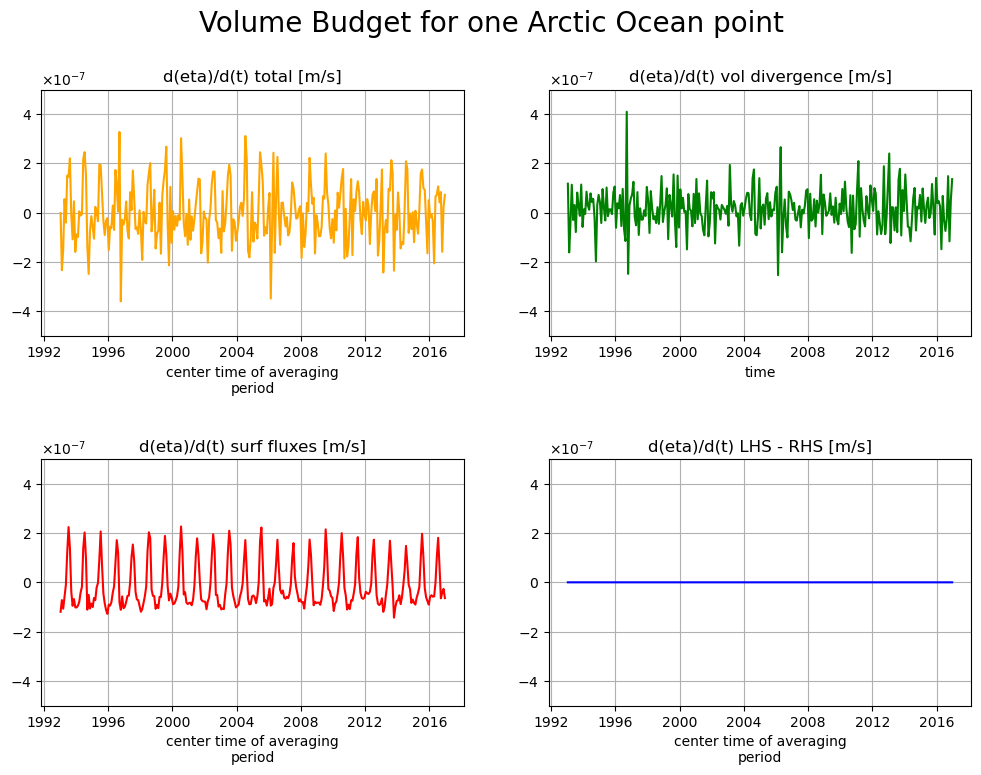

In [61]:
%%time

# Recall, from above...
a = G_total_tendency
b = G_vol_horiz_divergence_depth_integrated
c = G_surf_fluxes
d = a-b-c

plot_tile = 6
plot_j = 40
plot_i = 29
# tmp_aa = a.isel(tile=plot_tile,j=plot_j,i=plot_i)
# tmp_bb = b.isel(tile=plot_tile,j=plot_j,i=plot_i)
# tmp_cc = c.isel(tile=plot_tile,j=plot_j,i=plot_i)
# tmp_dd = d.isel(tile=plot_tile,j=plot_j,i=plot_i)

# use superchunks again (1 year = 1 superchunk) to partition computation
# and improve performance in limited-memory 
tmp_aa = np.empty((a.sizes['time'],))
tmp_bb = np.empty((b.sizes['time'],))
tmp_cc = np.empty((c.sizes['time'],))
size_superchunk = 12
for time_superchunk in range(int(np.ceil(b.sizes['time']/size_superchunk))):
    curr_time_ind = np.arange(size_superchunk*time_superchunk,\
                              np.fmin(size_superchunk*(time_superchunk+1),\
                                      b.sizes['time']))
    tmp_aa[curr_time_ind] = G_total_tendency.isel(time=curr_time_ind,\
                                                  tile=plot_tile,j=plot_j,i=plot_i).compute()
    tmp_bb[curr_time_ind] = G_vol_horiz_divergence_depth_integrated.isel(time=curr_time_ind,\
                                                                         tile=plot_tile,j=plot_j,i=plot_i).compute()
    tmp_cc[curr_time_ind] = G_surf_fluxes.isel(time=curr_time_ind,\
                                               tile=plot_tile,j=plot_j,i=plot_i).compute()
    print(f'Completed time_superchunk = {time_superchunk}')
tmp_dd = tmp_aa-tmp_bb-tmp_cc

tmp_aa = xr.DataArray(data=tmp_aa,dims=['time'],coords=a.isel(tile=plot_tile,j=plot_j,i=plot_i).coords)
tmp_bb = xr.DataArray(data=tmp_bb,dims=['time'],coords=b.isel(tile=plot_tile,j=plot_j,i=plot_i).coords)
tmp_cc = xr.DataArray(data=tmp_cc,dims=['time'],coords=c.isel(tile=plot_tile,j=plot_j,i=plot_i).coords)
tmp_dd = xr.DataArray(data=tmp_dd,dims=['time'],coords=d.isel(tile=plot_tile,j=plot_j,i=plot_i).coords)

fig, axs = plt.subplots(2, 2, figsize=(12,8))
plt.sca(axs[0,0])
tmp_aa.plot(color='orange')
axs[0,0].set_title("d(eta)/d(t) total [m/s]")
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.ylim([-5e-7, 5e-7]);
plt.grid()

plt.sca(axs[0,1])
tmp_bb.plot(color='g')
axs[0,1].set_title("d(eta)/d(t) vol divergence [m/s]")
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.ylim([-5e-7, 5e-7]);
plt.grid()

plt.sca(axs[1,0])
tmp_cc.plot(color='r')
axs[1,0].set_title("d(eta)/d(t) surf fluxes [m/s]")
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.ylim([-5e-7, 5e-7]);
plt.grid()

plt.sca(axs[1,1])
tmp_dd.plot(color='b')
axs[1,1].set_title("d(eta)/d(t) LHS - RHS [m/s]")
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.ylim([-5e-7, 5e-7]);
plt.grid()

plt.subplots_adjust(hspace = .5, wspace=.2)
plt.suptitle('Volume Budget for one Arctic Ocean point',
                 fontsize=20);

Indeed, the volume divergence term does contribute to $\eta$ variations at this one point.  

The seasonal cycle of surface fluxes from sea-ice growth and melt can be seen in the surface fluxes term (plotted below for just the year 1995)

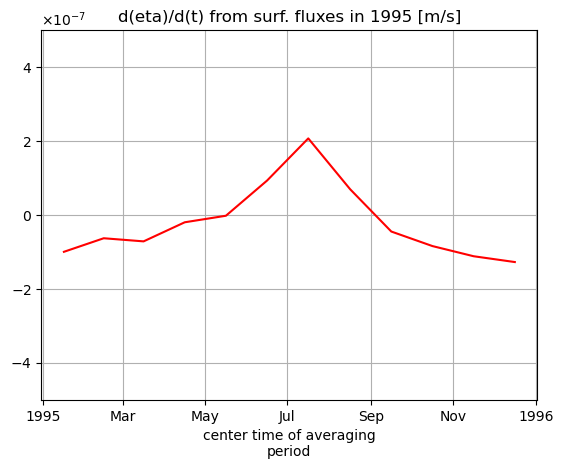

In [62]:
tmp_cc.sel(time='1995').plot(color='r')
plt.ticklabel_format(axis='y', style='sci', useMathText=True)
plt.ylim([-5e-7, 5e-7]);
plt.grid()
plt.title('d(eta)/d(t) from surf. fluxes in 1995 [m/s]');

## Predicted vs. actual $\eta$ 

As we have shown, in our Boussinesq model the only term that can change global mean model sea level anomaly $\eta$ is net surface freshwater flux.  Let us compare the time-evolution of $\eta$ implied by surface freshwater fluxes and the actual $\eta$ from the model output.

The predicted $\eta$ time series is calculated by time integrating **$G_{surface fluxes}$**.  
This time series is compared against the actual $\eta$ time series anomaly relative to the $\eta(t=0)$.

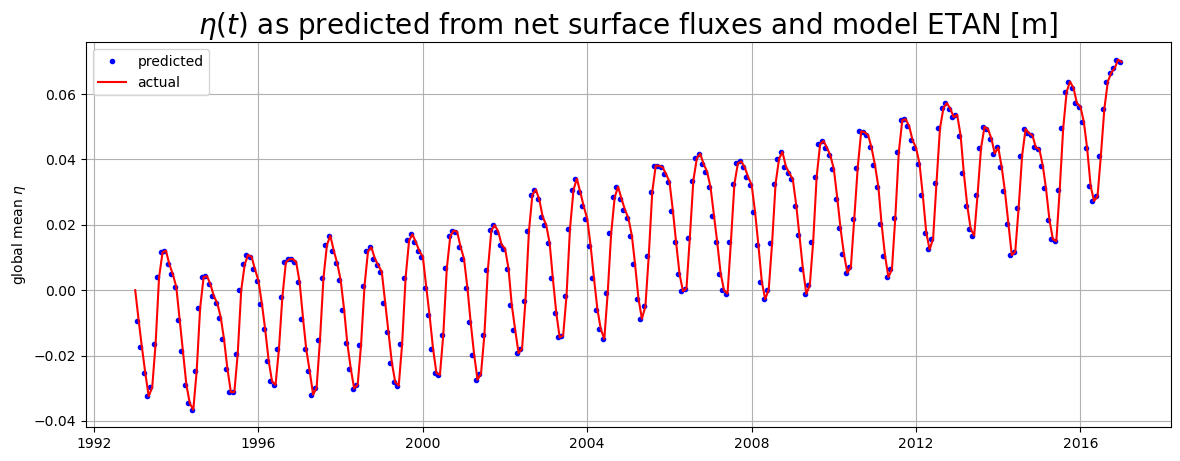

In [63]:
area_masked = ecco_grid.rA.where(ecco_grid.maskC.isel(k=0) == 1)

dETA_per_month_predicted_from_surf_fluxes = \
    ((G_surf_fluxes * area_masked).sum(dim=('i','j','tile')) / \
     area_masked.sum())*secs_per_month

ETA_predicted_by_surf_fluxes = \
    np.cumsum(dETA_per_month_predicted_from_surf_fluxes.values)

ETA_from_ETAN = \
    (ecco_monthly_snaps.ETAN * area_masked).sum(dim=('i','j','tile')) / \
    area_masked.sum().compute()

# plotting
plt.figure(figsize=(14,5))

plt.plot(dETA_per_month_predicted_from_surf_fluxes.time, \
         ETA_predicted_by_surf_fluxes,'b.')
plt.plot(ETA_from_ETAN.time.values, ETA_from_ETAN-ETA_from_ETAN.values[0],'r-')
plt.grid()
plt.ylabel('global mean $\eta$')
plt.legend(('predicted', 'actual'))
plt.title('$\eta(t)$ as predicted from net surface fluxes and model ETAN [m]', 
          fontsize=20)

The first predicted $\eta$ occurs at the end of the first month (one month time integral of $\partial \eta / \partial t$).  The first *actual* $\eta$ is set to be zero.

The above plot is another way of confirming that in our Boussinesq model the only term that can change global mean model sea level anomaly $\eta$ is net surface freshwater flux.  To account for changes in global mean density we must apply the Greatbatch correction, inverse-barometer correction, and a correction term to account for the fact that sea-ice does not 'float' on top of the ocean but in fact displaces seawater upwards.  All of these corrections are made for the term ``SSH``, dynamic sea surface height anomaly (not shown here).

One can compare the sea level rise from mass fluxes in ECCO vs those estimated from GRACE and other datasets published by the WCRP Global Sea Level Budget Group: Global sea-level budget 1993-present, Earth Syst. Sci. Data, 10, 1551-1590, https://doi.org/10.5194/essd-10-1551-2018, 2018. 

Available here.  See Figure 16.
https://www.earth-syst-sci-data.net/10/1551/2018/essd-10-1551-2018.pdf

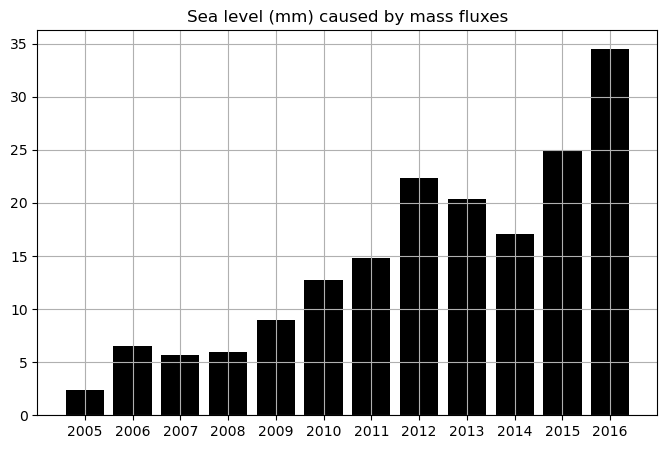

In [64]:
# Annual mean SL calculation must account for different lengths of each month.

# step 1. weight predicted eta by seconds in each month
tmp1=ETA_predicted_by_surf_fluxes*secs_per_month
# step 2, group records by year and sum across each year
tmp2=tmp1.groupby('time.year').sum()
# step 3, group secs per month by year and sum across each year
secs_per_year = secs_per_month.groupby('time.year').sum()

# step 3, divide time-weighted ETA by seconds per year
annual_mean_GMSL_due_to_mass_fluxes =tmp2/secs_per_year
num_years = len(annual_mean_GMSL_due_to_mass_fluxes.year.values)

plt.figure(figsize=(8,5));
# the -0.13 is to make the starting value comparable with WCRP fig 16.
plt.bar(annual_mean_GMSL_due_to_mass_fluxes.year.values[12:num_years],\
        1000*(annual_mean_GMSL_due_to_mass_fluxes.values[12:num_years]-.017), \
        color='k')
plt.grid()
plt.xticks(np.arange(2005, 
                     annual_mean_GMSL_due_to_mass_fluxes.year.values[-1]+1,step=1));
plt.title('Sea level (mm) caused by mass fluxes');

vs the WCRP data:

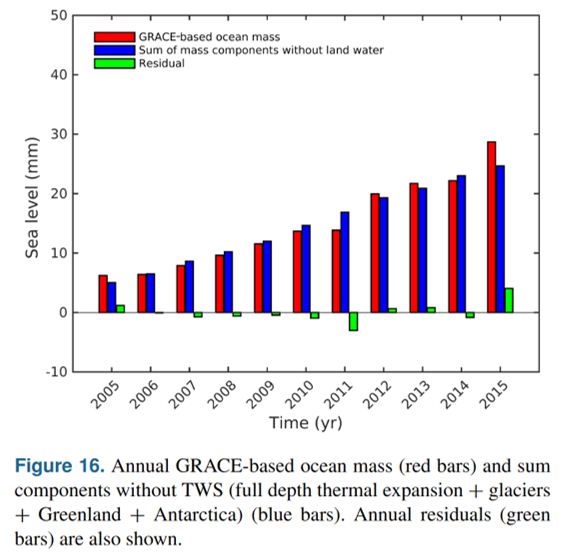

In [65]:
from IPython.display import Image
Image('../figures/cazenave_ocean_mass.png')

## Time-mean $\partial \eta / \partial t$ due to net freshwater fluxes

We can easily calculate the time mean rate of global sea level rise due to net freshwater flux.

In [66]:
x=(G_surf_fluxes_mean * area_masked).sum() / area_masked.sum()
total_GMSLR_due_to_mass_fluxes = x*seconds_in_entire_period
print('total global mean sea level rise due to mass fluxes m: ', \
      total_GMSLR_due_to_mass_fluxes.values)

total global mean sea level rise due to mass fluxes m:  0.06982078709392553


Dividing this by the total number of years in the analysis period gives a average rate per year:

In [67]:
total_number_of_years = len(secs_per_month)/12
total_number_of_years

24.0

In [68]:
mean_rate_of_GMSLR_due_to_mass_fluxes = \
    total_GMSLR_due_to_mass_fluxes/total_number_of_years

print('mean rate of GMSLR due to mass fluxes [mm/yr] ',  \
      1000*mean_rate_of_GMSLR_due_to_mass_fluxes.values)

mean rate of GMSLR due to mass fluxes [mm/yr]  2.909199462246897


Compare with other estimates of GMSLR due to mass fluxes.

## Remaining components of sea surface height

In [69]:
# estimate "snapshots" of global mean steric height anomaly at month boundaries
ds_glo_steric = ea.ecco_podaac_to_xrdataset('ster',time_res='daily',\
                                            StartDate='1993-01',EndDate='2017-01',\
                                            mode=access_mode,\
                                            download_root_dir=download_root_dir,\
                                            jsons_root_dir=jsons_root_dir)
glo_steric_monthly_snaps = ds_glo_steric.global_mean_sterodynamic_sea_level_anomaly\
                            .interp(time=ecco_monthly_snaps.time)

ShortName Options for query "ster":
                  Variable Name     Description (units)

Option 1: ECCO_L4_GMSL_TIME_SERIES_DAILY_V4R4    *daily means*
                  global_mean_barystatic_sea_level_anomaly
                                    Global mean of barystatic sea level anomaly (m)
                  global_mean_sterodynamic_sea_level_anomaly
                                    Global mean of sterodynamic sea level anomaly (m)
                  global_mean_sea_level_anomaly
                                    Global mean of dynamic SSH (m)




Proceed with option 1? [y/n]:  y


Using dataset with ShortName: ECCO_L4_GMSL_TIME_SERIES_DAILY_V4R4
{'ShortName': 'ECCO_L4_GMSL_TIME_SERIES_DAILY_V4R4', 'temporal': '1993-01-02,2017-01-31'}

Total number of matching granules: 1


In [70]:
# retrieve sea ice load (mass) per unit area
ds_siceload = ea.ecco_podaac_to_xrdataset('siceload',time_res='snapshot',\
                                          StartDate='1993-01',EndDate='2016-12',\
                                          snapshot_interval='monthly',\
                                          mode=access_mode,\
                                          download_root_dir=download_root_dir,\
                                          jsons_root_dir=jsons_root_dir)

ShortName Options for query "siceload":
                  Variable Name     Description (units)

Option 1: ECCO_L4_SEA_ICE_CONC_THICKNESS_LLC0090GRID_SNAPSHOT_V4R4    *native grid,snapshots at daily intervals*
                  SIarea            Sea-ice concentration (fraction between 0 and 1)
                  SIheff            Area-averaged sea-ice thickness (m)
                  SIhsnow           Area-averaged snow thickness (m)
                  sIceLoad          Average sea-ice and snow mass per unit area
                                    (kg/m^2)




Proceed with option 1? [y/n]:  y


Using dataset with ShortName: ECCO_L4_SEA_ICE_CONC_THICKNESS_LLC0090GRID_SNAPSHOT_V4R4


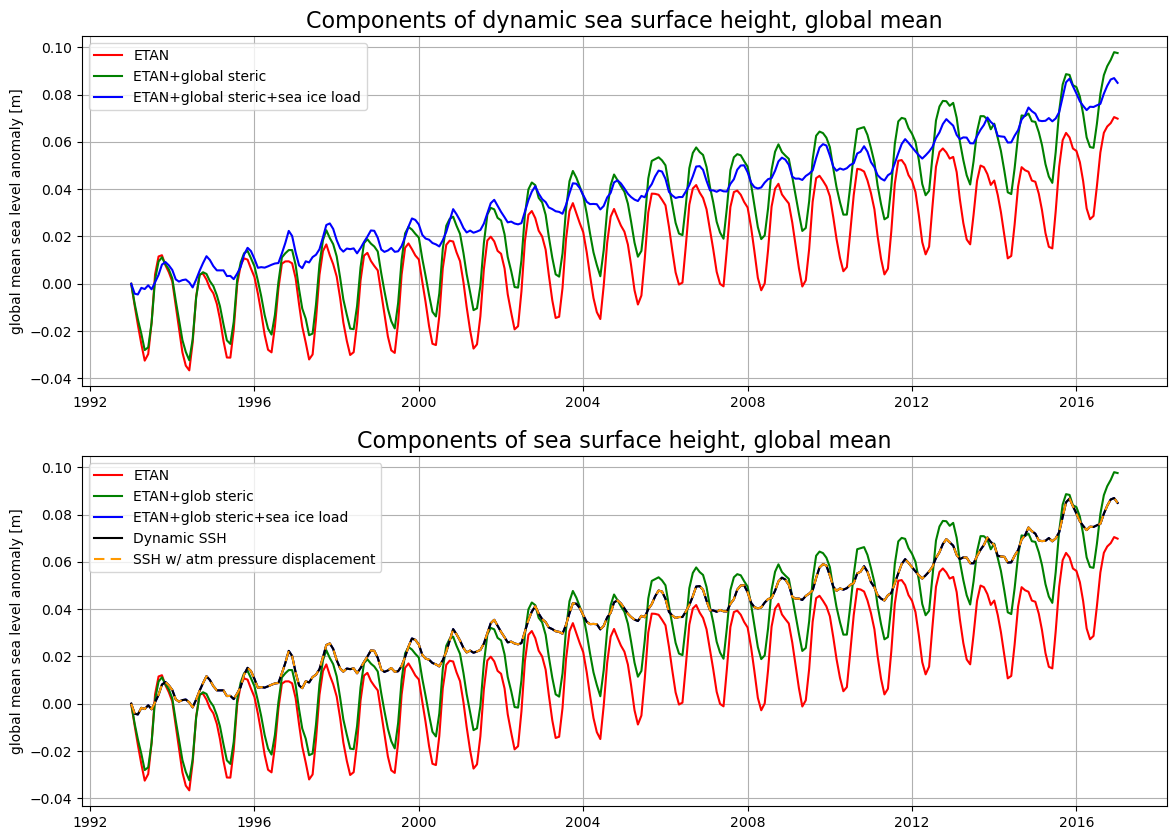

In [71]:
# global mean sea ice load correction
rhoConst = 1029
sIceLoad_m = ds_siceload.sIceLoad/rhoConst
sIceLoad_m_globmean = \
    (sIceLoad_m * area_masked).sum(dim=('i','j','tile')) / \
    area_masked_sum

# adding components to ETAN
ETA_plus_glob_steric = ETA_from_ETAN + glo_steric_monthly_snaps
ETA_plus_glob_steric_sIceLoad = ETA_plus_glob_steric + sIceLoad_m_globmean

# global mean dynamic SSH
SSH_globmean = \
    (ds_dict[ShortNames_list[-2]]['SSH'] * area_masked).sum(dim=('i','j','tile')) / \
    area_masked_sum

# global mean SSH, with inverted barometer effect
SSHNOIBC_globmean = \
    (ds_dict[ShortNames_list[-2]]['SSHNOIBC'] * area_masked).sum(dim=('i','j','tile')) / \
    area_masked_sum



# plotting
fig,ax = plt.subplots(2,1,figsize=(14,10))

ax[0].plot(ETA_from_ETAN.time.values, (ETA_from_ETAN-ETA_from_ETAN[0]).values,'r-')
ax[0].plot(ETA_from_ETAN.time.values, (ETA_plus_glob_steric - ETA_plus_glob_steric[0]).values,'g-')
ax[0].plot(ETA_from_ETAN.time.values, (ETA_plus_glob_steric_sIceLoad \
                                     - ETA_plus_glob_steric_sIceLoad[0]).values,'b-')
# plt.plot(SSH_globmean.time.values, (SSH_globmean - SSH_globmean[0]).values,'k-')
ax[0].grid()
ax[0].set_ylabel('global mean sea level anomaly [m]')
ax[0].legend(('ETAN','ETAN+global steric','ETAN+global steric+sea ice load'))
# plt.legend(('ETAN','ETAN+glob steric','ETAN+glob steric+sea ice load','Dynamic SSH'))
ax[0].set_title('Components of dynamic sea surface height, global mean', 
          fontsize=16)

ax[1].plot(ETA_from_ETAN.time.values, (ETA_from_ETAN-ETA_from_ETAN[0]).values,'r-')
ax[1].plot(ETA_from_ETAN.time.values, (ETA_plus_glob_steric - ETA_plus_glob_steric[0]).values,'g-')
ax[1].plot(ETA_from_ETAN.time.values, (ETA_plus_glob_steric_sIceLoad \
                                     - ETA_plus_glob_steric_sIceLoad[0]).values,'b-')
ax[1].plot(SSH_globmean.time.values, (SSH_globmean - SSH_globmean[0]).values,'k-')
ax[1].plot(SSHNOIBC_globmean.time.values, (SSHNOIBC_globmean - SSHNOIBC_globmean[0]).values,\
           color=(1,.6,0),linestyle=(0,(5,3)))
ax[1].grid()
ax[1].set_ylabel('global mean sea level anomaly [m]')
ax[1].legend(('ETAN','ETAN+glob steric','ETAN+glob steric+sea ice load','Dynamic SSH','SSH w/ atm pressure displacement'))
ax[1].set_title('Components of sea surface height, global mean', 
          fontsize=16)
plt.show()

Note that ETAN+glob steric+sea ice load = dynamic SSH (this is true even for individual grid cells). In the global mean, dynamic SSH = SSH with the atmospheric pressure displacement (inverted barometer effect), but this will not be true for individual grid cells.